### Udacity Data Science Nanodegree
### Project 1: Writing a Data Scientist Blog Post
---

# Part I - London Airbnb Data - Data Wrangling
## by Juanita Smith


- [Introduction](#intro)
- [Step 1: Data Gathering](#datagathering)
- [Step 2: Assessing](#assessing)
- [Step 3: Data Cleaning](#clean)
- [Step 4: Save cleaned data](#save)
- [References](#references)
- [Submission](#submission)

<a id='intro'></a>
<span style="color:blue; font-size:25px; line-height:30px; font-family: Calibri;"> Introduction</span>


## Are you like me going the Taylor Swift concert in London next June and looking for the best place to stay ?

This project will focus on answering questions below.  

#### 1) Are some hosts running a business, and if so, what is the impact on price ?
> - Should we distinguish between short-term and long-term rentals, and how does it effect the daily average price ?
> - Are some hosts running a business with multiple listings ? If so, how does this affect the price ?


#### 2) Host Analysis: How does **host excellence** influence price ?
> - Super hosts seems to describe their properties better, how does this effect price and availability ?


#### 3) What effect does **star ratings** have on property price ?
> - Would a 5-star vs 3-star listing in the same location cost more ?


#### 4) Predict average daily listing price
> - Knowing the impact of host excellence and star ratings above, could we make an accurate average daily price prediction ?


### Context:
Since 2008, guests and hosts have used Airbnb to travel in a more unique, personalized way. As part of the Airbnb Inside initiative, open source data was downloaded that describes the listing activity of homestays in London, United Kingdom.


### Dictionary:

The following Airbnb activity is included in this London dataset and is snapshot of booking availability on 8 June 2023.

Data was downloaded from Airbnb [here](http://insideairbnb.com/get-the-data/). Scroll down to London section

- Listings, including full descriptions and average review score
- Reviews, including unique id for each reviewer and detailed comments
- Calendar, including listing id and the price and availability for a whole year ahead by day

Metadata are available [here](https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit#gid=1322284596)

In [1]:
# import all packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import glob
import os
import missingno as msno
from datetime import datetime

# from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer

# clear the garbage to free memory as we are working with huge datasets
import gc 

# import warnings
# warnings.filterwarnings("ignore")

# Import custom modules
from project1_blog.src.utils import reduce_mem_usage, create_folder
import project1_blog.src.visuals as vs

# set plots to be embedded inline
%matplotlib inline

# suppress matplotlib user warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

# use high resolution if this project is run on an apple device
# %config InlineBackend.figure_format='retina'

# Make your Jupyter Notebook wider
from IPython.display import display, HTML
display(HTML('<style>.container { width:80% !important; }</style>'))

# environment settings
# display all columns and rows during visual inspection
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# stop scientific notation on graphs
pd.options.display.float_format = '{:.0f}'.format

In [2]:
# sns.set_style("whitegrid")
# BASE_COLOR = sns.color_palette()[0]

In [3]:
# set default plot formatting
BASE_COLOR, BASE_HIGHLIGHT_INTENSE, BASE_HIGHLIGHT, BASE_COMPLEMENTRY, BASE_GREY, BASE_COLOR_ARR, BASE_COLOR_DEP, SYMBOLS = vs.set_plot_defaults()

In [4]:
FILE_PATH_RAW = '../data/raw/'
FILE_PATH_CLEAN = '../data/clean/'
FILE_NAME_CLEAN = '../data/clean/listing_clean.pkl'

<a id='datagathering'></a>
<span style="color:blue; font-size:25px; line-height:30px; font-family: Calibri;">Step 1: Data Gathering</span>

This dataset is part of Airbnb Inside, and the original source data can be found [here](http://insideairbnb.com/get-the-data/)

In [5]:
# get calendar data
filename = FILE_PATH_RAW + 'calendar/london/calendar_060623.csv'
calendar = pd.read_csv(filename)
calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,13913,2023-06-09,f,$79.00,$79.00,1,29
1,13913,2023-06-10,f,$79.00,$79.00,1,29
2,13913,2023-06-11,f,$79.00,$79.00,1,29
3,13913,2023-06-12,t,$79.00,$79.00,1,29
4,13913,2023-06-13,t,$79.00,$79.00,1,29


In [6]:
# get review data
filename = FILE_PATH_RAW + 'reviews/london/reviews_060623.csv'
review = pd.read_csv(filename)
review.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,306333,121679704,2016-12-18,8698767,Ben,"Great find, and great value! <br/>Right in th..."
1,154221,59561487,2016-01-12,1655084,Daria,Small and cosy flat with all goods you need in...
2,306333,122121197,2016-12-21,72253091,Matthew,A quiet house in the Hoxton area. Felt very ho...
3,306333,123425430,2016-12-29,18523201,Kom,"We had a great stay in London, and Rob's flat ..."
4,306333,126479992,2017-01-12,9940848,Marisa,This flat is perfect if you are interested in ...


In [7]:
# get listing data
filename = FILE_PATH_RAW + 'listings/london/listings_060623.csv'
listing = pd.read_csv(filename)
listing.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,154221,https://www.airbnb.com/rooms/154221,20230608145305,2023-06-10,previous scrape,Rental unit in London · 2 bedrooms · 2 beds · ...,"hi, i am renting my 2 bedroom flat in Pimlico ...","a very save area of central London , Pimlico i...",https://a0.muscache.com/pictures/3510524/72655...,211018,https://www.airbnb.com/users/show/211018,Sylvia,2010-08-24,"Rome, Italy",i love to travel and therefor want to give my ...,NaN,NaN,NaN,f,https://a0.muscache.com/im/users/211018/profil...,https://a0.muscache.com/im/users/211018/profil...,Pimlico,1,5,"['email', 'phone']",t,f,"London, England, United Kingdom",Westminster,NaN,51,-0,Entire rental unit,Entire home/apt,3,NaN,1 bath,2,2,"[""TV"", ""Microwave"", ""Dishwasher"", ""Wifi"", ""Ref...",$83.00,2,30,2,2,30,30,2,30,NaN,t,0,0,0,0,2023-06-10,1,0,0,2016-01-12,2016-01-12,5,5,5,5,5,5,5,NaN,f,1,1,0,0,0
1,157714,https://www.airbnb.com/rooms/157714,20230608145305,2023-06-09,city scrape,Townhouse in Hammersmith · ★4.71 · 1 bedroom ·...,"Large, light and spacious loft bedroom with a ...",The neighbourhood is extremely convenient for ...,https://a0.muscache.com/pictures/4129744/10db5...,757377,https://www.airbnb.com/users/show/757377,Eilinn,2011-06-29,"London, United Kingdom","Eilinn, Yoon our daughters Surei and Sukyi wou...",within a few hours,90%,68%,NaN,https://a0.muscache.com/im/users/757377/profil...,https://a0.muscache.com/im/users/757377/profil...,Hammersmith,1,2,"['email', 'phone']",t,t,"Hammersmith, England, United Kingdom",Hammersmith and Fulham,NaN,51,-0,Private room in townhouse,Private room,3,NaN,1.5 baths,NaN,1,"[""Room-darkening shades"", ""Hot water"", ""Securi...",$69.00,4,21,4,4,21,21,4,21,NaN,t,10,37,67,67,2023-06-09,175,10,0,2011-07-13,2023-05-02,5,5,5,5,5,5,5,NaN,f,1,0,1,0,1
2,13913,https://www.airbnb.com/rooms/13913,20230608145305,2023-06-09,city scrape,Rental unit in Islington · ★4.80 · 1 bedroom ·...,My bright double bedroom with a large window h...,Finsbury Park is a friendly melting pot commun...,https://a0.muscache.com/pictures/miso/Hosting-...,54730,https://www.airbnb.com/users/show/54730,Alina,2009-11-16,"London, United Kingdom",I am a Multi-Media Visual Artist and Creative ...,within an hour,100%,78%,NaN,https://a0.muscache.com/im/users/54730/profile...,https://a0.muscache.com/im/users/54730/profile...,LB of Islington,3,4,"['email', 'phone']",t,t,"Islington, Greater London, United Kingdom",Islington,NaN,52,-0,Private room in rental unit,Private room,1,NaN,1 shared bath,NaN,1,"[""Room-darkening shades"", ""Freezer"", ""Oven"", ""...",$79.00,1,29,1,1,29,29,1,29,NaN,t,23,48,78,353,2023-06-09,41,15,0,2010-08-18,2022-12-11,5,5,5,5,5,5,5,NaN,f,2,1,1,0,0
3,15400,https://ww

In [8]:
# get listing summary data
filename = FILE_PATH_RAW + 'listings_summary/london/listings_summary_060623.csv'
listing_summary = pd.read_csv(filename)
listing_summary.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,306333,Rental unit in London · ★4.32 · 2 bedrooms · 3...,1573870,Robert,NaN,Hackney,52,-0,Entire home/apt,156,2,20,2017-05-31,0,1,4,0,NaN
1,154221,Rental unit in London · 2 bedrooms · 2 beds · ...,211018,Sylvia,NaN,Westminster,51,-0,Entire home/apt,83,2,1,2016-01-12,0,1,0,0,NaN
2,306405,Rental unit in Dagenham · ★4.0 · 1 bedroom · 1...,1575800,Mary,NaN,Barking and Dagenham,52,0,Private room,41,4,3,2012-05-27,0,1,365,0,NaN
3,157714,Townhouse in Hammersmith · ★4.71 · 1 bedroom ·...,757377,Eilinn,NaN,Hammersmith and Fulham,51,-0,Private room,69,4,175,2023-05-02,1,1,67,10,NaN
4,13913,Rental unit in Islington · ★4.80 · 1 bedroom ·...,54730,Alina,NaN,Islington,52,-0,Private room,79,1,41,2022-12-11,0,2,353,15,NaN


<a id='assessing'></a>
<span style="color:blue; font-size:25px; line-height:30px; font-family: Calibri;">Step 2: Assessing</span>

### 2.1 Assessing `calendar` dataset

In [9]:
# visual inspection
calendar.head(10)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,13913,2023-06-09,f,$79.00,$79.00,1,29
1,13913,2023-06-10,f,$79.00,$79.00,1,29
2,13913,2023-06-11,f,$79.00,$79.00,1,29
3,13913,2023-06-12,t,$79.00,$79.00,1,29
4,13913,2023-06-13,t,$79.00,$79.00,1,29
5,13913,2023-06-14,t,$79.00,$79.00,1,29
6,13913,2023-06-15,t,$79.00,$79.00,1,29
7,13913,2023-06-16,t,$79.00,$79.00,1,29
8,13913,2023-06-17,f,$79.00,$79.00,1,29
9,13913,2023-06-18,t,$79.00,$79.00,1,29


>**Observations from visual inspection:**

      - Multiple records for each listing_id exist, let's explore that deeper to build data understanding

#### What is the structure of the dataset?

In [10]:
calendar.shape

(29853384, 7)

>**Observation:**

      - Watchout dataset almost 30mil records, avoid row level coding

#### Inspect the data types and missing values

In [11]:
calendar.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29853384 entries, 0 to 29853383
Data columns (total 7 columns):
 #   Column          Non-Null Count     Dtype  
---  ------          --------------     -----  
 0   listing_id      29853384 non-null  int64  
 1   date            29853384 non-null  object 
 2   available       29853384 non-null  object 
 3   price           29852291 non-null  object 
 4   adjusted_price  29852291 non-null  object 
 5   minimum_nights  29851239 non-null  float64
 6   maximum_nights  29851239 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 1.6+ GB


>**Observation:**

      - date field is a string
      - price and adjusted price columns are strings
      - there are no missing entries

##### Inspect descriptive statistics

In [12]:
calendar.describe([0.25, 0.5, 0.75, 0.85, 0.9, 0.95, 0.99], include='all')

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
count,29853384,29853384,29853384,29852291,29852291,29851239,29851239
unique,NaN,369,2,4716,4699,NaN,NaN
top,NaN,2024-05-26,f,$100.00,$100.00,NaN,NaN
freq,NaN,81791,20088147,859842,848475,NaN,NaN
mean,297404990065705216,NaN,NaN,NaN,NaN,8,522178
std,379219081185045504,NaN,NaN,NaN,NaN,32,33453795
min,13913,NaN,NaN,NaN,NaN,1,1
25%,21053002,NaN,NaN,NaN,NaN,1,99
50%,43120044,NaN,NaN,NaN,NaN,2,1125
75%,729314415948940032,NaN,NaN,NaN,NaN,5,1125


In [13]:
calendar.loc[calendar['minimum_nights'] > 1000].nunique()

listing_id          4
date              366
available           2
price               5
adjusted_price      5
minimum_nights      2
maximum_nights      2
dtype: int64

>**Observation:**
    
      - There are 5 listings with minimum_nights > 1000 days which looks like long term rentals over 3 years
      - 90% of listings have a minimum stay < 9 days, which signals holiday/short term rentals
      - 1% of listings have minimum stays > 90 days, which indicates again long term rental

#### What are the date range of property listings?

In [14]:
print('Date range for listings: {} to {}'.format(calendar['date'].min(), calendar['date'].max()))

Date range for listings: 2023-06-08 to 2024-06-10


>**Observations:**

      - Dataset contain data for just over a 1 year period looking forward into the next 12 months

##### Inspect unique values

In [15]:
calendar.nunique()

listing_id        81791
date                369
available             2
price              4716
adjusted_price     4699
minimum_nights      153
maximum_nights      771
dtype: int64

In [16]:
calendar['available'].unique()

array(['f', 't'], dtype=object)

>**Observations from unique values:**

      - over 80k properties are listed for 2023/2024 period
      - we have an entry for each day of the 1 year period for each listing
      - `available` is a boolean field with f(false) and t(true) values

##### Inspect the calendar entries for a single property to understand how the data is structured

In [17]:
# Analyse records for the first property listing

# get first property id
listing_id = calendar.iloc[0][0]

first_listing = calendar[calendar.listing_id == listing_id]
first_listing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 365 entries, 0 to 364
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   listing_id      365 non-null    int64  
 1   date            365 non-null    object 
 2   available       365 non-null    object 
 3   price           365 non-null    object 
 4   adjusted_price  365 non-null    object 
 5   minimum_nights  365 non-null    float64
 6   maximum_nights  365 non-null    float64
dtypes: float64(2), int64(1), object(4)
memory usage: 22.8+ KB


/var/folders/4p/r9m3gynn3wj6h4yh4_lwz5fw0000gn/T/ipykernel_11560/58997714.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  listing_id = calendar.iloc[0][0]


In [18]:
first_listing['available'].value_counts()

available
t    353
f     12
Name: count, dtype: int64

In [19]:
first_listing

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,13913,2023-06-09,f,$79.00,$79.00,1,29
1,13913,2023-06-10,f,$79.00,$79.00,1,29
2,13913,2023-06-11,f,$79.00,$79.00,1,29
3,13913,2023-06-12,t,$79.00,$79.00,1,29
4,13913,2023-06-13,t,$79.00,$79.00,1,29
5,13913,2023-06-14,t,$79.00,$79.00,1,29
6,13913,2023-06-15,t,$79.00,$79.00,1,29
7,13913,2023-06-16,t,$79.00,$79.00,1,29
8,13913,2023-06-17,f,$79.00,$79.00,1,29
9,13913,2023-06-18,t,$79.00,$79.00,1,29


>**Observations:** 

      - Each listing has an entry in the calendar table for the full year ahead, listing when the property is available to rent or already booked

##### Can we detect what is the difference between price and adjusted price ?

In [20]:
# get a listing id where price and adjusted prices is different
listing_id_price = calendar[calendar.price != calendar.adjusted_price].iloc[10][0]
calendar[calendar.listing_id == listing_id_price][:20]

/var/folders/4p/r9m3gynn3wj6h4yh4_lwz5fw0000gn/T/ipykernel_11560/3180353798.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  listing_id_price = calendar[calendar.price != calendar.adjusted_price].iloc[10][0]


,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
43158,264777,2023-06-09,f,$110.00,$105.00,3,365
43159,264777,2023-06-10,f,$110.00,$105.00,3,365
43160,264777,2023-06-11,f,$100.00,$95.00,3,365
43161,264777,2023-06-12,f,$100.00,$100.00,3,365
43162,264777,2023-06-13,f,$100.00,$100.00,3,365
43163,264777,2023-06-14,f,$100.00,$100.00,3,365
43164,264777,2023-06-15,f,$100.00,$100.00,3,365
43165,264777,2023-06-16,f,$110.00,$110.00,3,365
43166,264777,2023-06-17,f,$110.00,$110.00,3,365
43167,264777,2023-06-18,f,$100.00,$100.00,3,365


In [21]:
# what is daily price in the listing
listing[listing.id == listing_id_price]['price']

167    $101.00
Name: price, dtype: object

In [22]:
# how many records have price and adjusted price different ?
records_price_diff = len(calendar[calendar.price != calendar.adjusted_price])
print('Number of records with price and adjusted price differences are {} of {}'.format(records_price_diff, calendar.shape[0]))

Number of records with price and adjusted price differences are 853302 of 29853384


>**Observation**: The daily price for above example listing is $101 and that is how it appear on the listing advert on Airbnb. However the price in calendar dataset fluctuate depending on season and demand. It is not clear what is the difference between price and adjusted price, I assume it's ok to ignore adjusted price.

### 2.2 Assessing `listing` dataset

#### Visual inspection

In [23]:
listing.sample(5)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
47255,51995358,https://www.airbnb.com/rooms/51995358,20230608145305,2023-06-09,city scrape,Condo in Greater London · ★4.85 · 1 bedroom · ...,Switch off or log in from the comfort of your ...,Your neighbourhood: Canary Wharf <br /><br />...,https://a0.muscache.com/pictures/miso/Hosting-...,421067512,https://www.airbnb.com/users/show/421067512,Landmark Pinnacle,2021-09-01,NaN,NaN,within an hour,92%,98%,f,https://a0.muscache.com/im/pictures/user/07335...,https://a0.muscache.com/im/pictures/user/07335...,NaN,6,6,"['email', 'phone']",t,t,"Greater London, England, United Kingdom",Tower Hamlets,NaN,52,-0,Entire condo,Entire home/apt,3,NaN,1 bath,1,2,"[""Room-darkening shades"", ""Freezer"", ""Oven"", ""...",$293.00,1,365,1,6,999,999,4,999,NaN,t,25,55,85,360,2023-06-09,131,79,8,2021-11-17,2023-05-27,5,5,5,5,5,5,5,NaN,t,6,6,0,0,7
75818,870744510221518413,https://www.airbnb.com/rooms/870744510221518413,20230608145305,2023-06-09,city scrape,Home in Greater London · ★New · 2 bedrooms · 3...,Relax with the whole family in this quiet acco...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,465521441,https://www.airbnb.com/users/show/465521441,Carlos,2022-06-22,NaN,NaN,within a few hours,90%,73%,NaN,https://a0.muscache.com/im/pictures/user/User-...,https://a0.muscache.com/im/pictures/user/User-...,NaN,5,5,"['email', 'phone']",t,t,NaN,Ealing,NaN,52,-0,Entire home,Entire home/apt,4,NaN,1 bath,2,3,"[""TV"", ""Free parking on premises"", ""Wifi"", ""Re...","$1,000.00",25,31,25,25,31,31,25,31,NaN,t,2,12,42,317,2023-06-09,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,5,2,3,0,NaN
23795,23715473,https://www.airbnb.com/rooms/23715473,20230608145305,2023-06-10,previous scrape,Rental unit in Greater London · ★4.29 · 2 bedr...,Available from 29th may to 29th june 2021. <br...,Probably one of the most diverse and sophistic...,https://a0.muscache.com/pictures/83e6c415-62a6...,177721917,https://www.airbnb.com/users/show/177721917,John,2018-03-10,"England, United Kingdom",senior professional living within 5 minutes wa...,within a few hours,100%,0%,f,https://a0.muscache.com/im/pictures/user/5dca5...,https://a0.muscache.com/im/pictures/user/5dca5...,Marylebone,1,1,"['email', 'phone']",t,t,"Greater London, England, United Kingdom",Westminster,NaN,52,-0,Entire rental unit,Entire home/apt,5,NaN,1 bath,2,3,"[""Room-darkening shades"", ""Oven"", ""Hot water"",...",$88.00,6,11,6,6,11,11,6,11,NaN,t,0,0,0,0,2023-06-10,10,0,0,2018-04-25,2021-06-20,4,4,4,4,4,5,4,NaN,f,1,1,0,0,0
45349,50149879,https://www.airbnb.com/rooms/50149879,20230608145305,2023-06-10,previous scrape,Condo in Greater London · ★4.56 · 1 bedroom · ...,Charming spacious first-floor open-plan mod

>**Observations from visual inspection:**

      - column name `id` in the listings dataset is the same as column `listing_id` in the calendar dataset
      - `bathroom` field is missing, whilst the number of bathrooms are present in a text field `bathrooms_text`
      - `amenities` have multiple values
      - `price` is a string containing '$'
      - when `bedrooms` are missing, `beds` are filled
      - when `bedrooms` are missing, the number of bedrooms are contained in text field `name`

#### What is the structure of the listing vs listing_summary dataset?

In [24]:
listing.shape, listing_summary.shape

((81791, 75), (81792, 18))

#### Inspect the data types and missing values of both listing and listing_summary to compare the difference

In [25]:
listing.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81791 entries, 0 to 81790
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            81791 non-null  int64  
 1   listing_url                                   81791 non-null  object 
 2   scrape_id                                     81791 non-null  int64  
 3   last_scraped                                  81791 non-null  object 
 4   source                                        81791 non-null  object 
 5   name                                          81791 non-null  object 
 6   description                                   80460 non-null  object 
 7   neighborhood_overview                         44633 non-null  object 
 8   picture_url                                   81790 non-null  object 
 9   host_id                                       81791 non-null 

In [26]:
listing_summary.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81792 entries, 0 to 81791
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              81792 non-null  int64  
 1   name                            81792 non-null  object 
 2   host_id                         81792 non-null  int64  
 3   host_name                       81786 non-null  object 
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   81792 non-null  object 
 6   latitude                        81792 non-null  float64
 7   longitude                       81792 non-null  float64
 8   room_type                       81792 non-null  object 
 9   price                           81792 non-null  int64  
 10  minimum_nights                  81792 non-null  int64  
 11  number_of_reviews               81792 non-null  int64  
 12  last_review                     

>**Observation:** `listing_summary` is a reduced version of `listing` containing less features, however `listing` have very interesting fields that could be useful for predictions. Lets rather focus on the listings dataset

##### Inspect unique values

In [27]:
listing.nunique()

id                                              81791
listing_url                                     81791
scrape_id                                           1
last_scraped                                        3
source                                              2
name                                            20766
description                                     74519
neighborhood_overview                           36423
picture_url                                     79624
host_id                                         50501
host_url                                        50501
host_name                                       14334
host_since                                       4658
host_location                                    1615
host_about                                      23216
host_response_time                                  4
host_response_rate                                 90
host_acceptance_rate                              100
host_is_superhost           

##### How many unique values are present in categorical variables

/var/folders/4p/r9m3gynn3wj6h4yh4_lwz5fw0000gn/T/ipykernel_11560/309653150.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90)
/var/folders/4p/r9m3gynn3wj6h4yh4_lwz5fw0000gn/T/ipykernel_11560/309653150.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90)
/var/folders/4p/r9m3gynn3wj6h4yh4_lwz5fw0000gn/T/ipykernel_11560/309653150.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90)
/var/folders/4p/r9m3gynn3wj6h4yh4_lwz5fw0000gn/T/ipykernel_11560/309653150.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotat

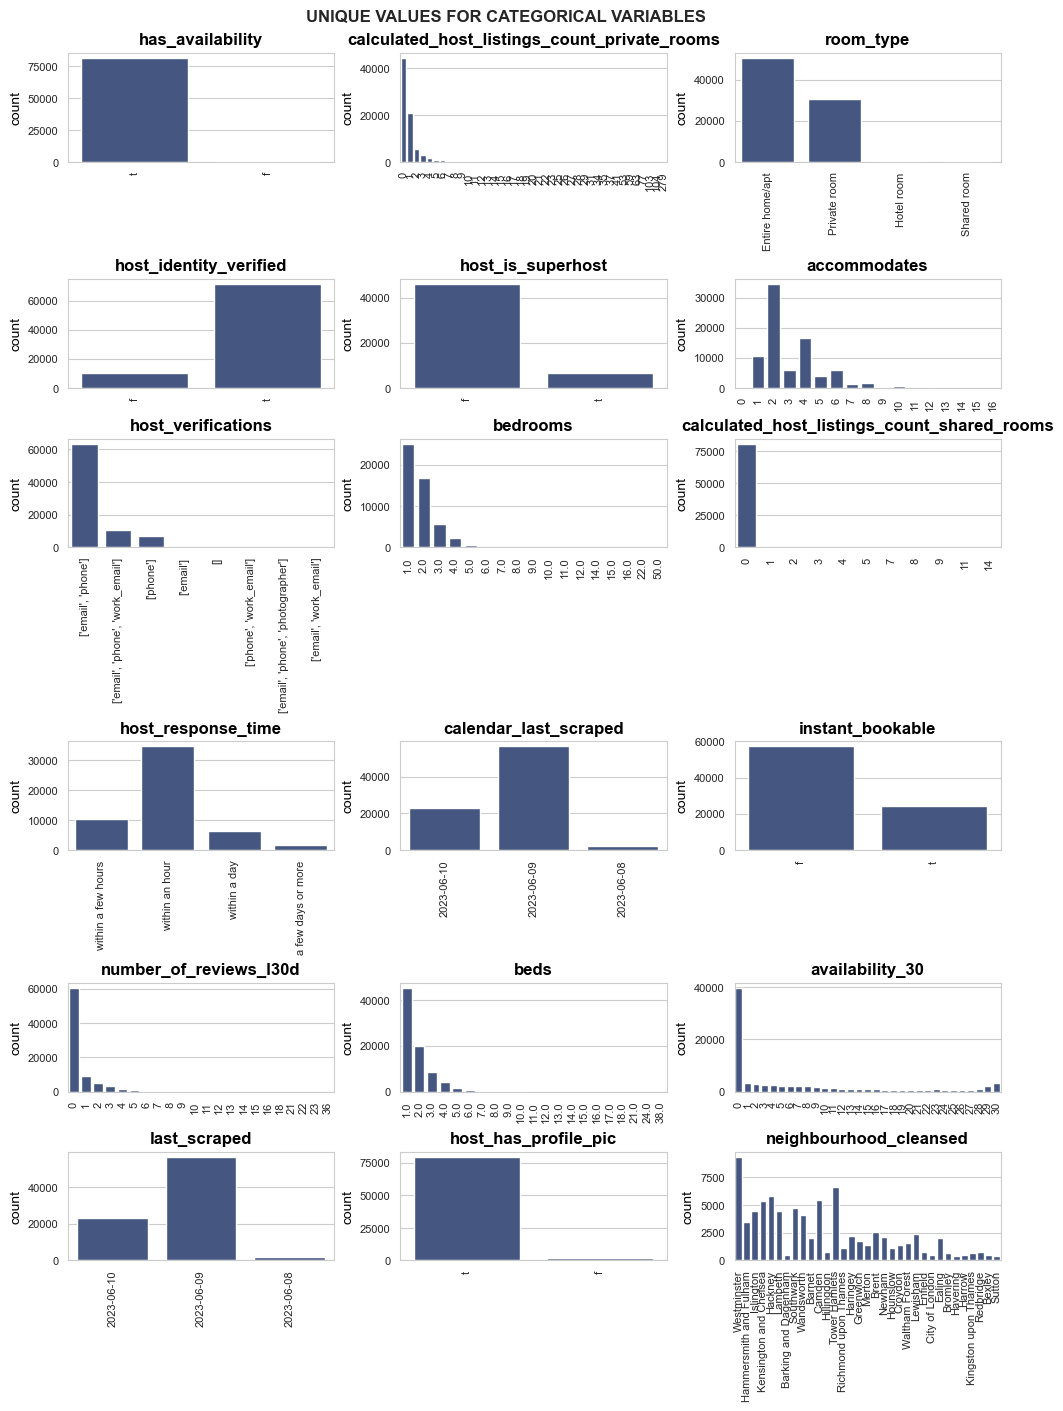

In [28]:
# get a list of categorical features
cat_cols = list(listing.select_dtypes(include=['object']).columns)


# get columns with 50 or less unique values and feature is categorical
# cols = set(listing.columns[(listing.nunique().between(2, 50)) & listing.columns.isin(cat_cols)])
cols = set(listing.columns[listing.nunique().between(2, 50)])

# print column unique values in a subplot grid
ncols = 3
nrows = len(cols) // ncols

fig, axs = plt.subplots(nrows, ncols, constrained_layout=True, figsize=(10,14))
for col, ax in zip(cols, axs.T.ravel()):
    sns.countplot(data=listing, x=col, ax=ax, color=BASE_COLOR, orient='h')
    
    # rotate the xtick labels
    labels = ax.get_xticklabels()
    ax.set_xticklabels(labels, rotation=90)
    ax.set_title(col)
    ax.set_xlabel('')

plt.suptitle('UNIQUE VALUES FOR CATEGORICAL VARIABLES')
plt.show()

In [29]:
# understand deeper the possible values of bathrooms_text
listing.bathrooms_text.value_counts()

bathrooms_text
1 bath               36300
1 shared bath        12062
2 baths               9838
1 private bath        6690
1.5 baths             6236
1.5 shared baths      3360
2.5 baths             2393
3 baths               1248
2 shared baths        1238
3.5 baths              658
2.5 shared baths       381
4 baths                237
3 shared baths         187
Half-bath              149
4.5 baths              131
5 baths                119
0 shared baths         106
0 baths                 85
Shared half-bath        59
3.5 shared baths        44
5.5 baths               32
6 baths                 19
4.5 shared baths        17
6.5 baths               15
Private half-bath       14
4 shared baths          14
12 baths                 9
5 shared baths           7
7.5 baths                5
7 baths                  4
5.5 shared baths         4
9 baths                  4
23 baths                 3
8 shared baths           2
7 shared baths           2
10.5 baths               2
6 shared bath

>**Observations from info and unique values:**

      - boolean fields have values 'f' and 't'
      - `host_verifications` have multiple values (email, phone, etc)
      - `host_since` is a date with type string
      - `host_response_rate` and `host_acceptance_rate` are numeric fields as type string with text '%' present
      - `neighbourhood` column is a duplicate of improved `neighbourhood_cleansed`
      - columns `neighbourhood_group_cleansed`, `calendar_updated` and `license ` have all values missing
      - calendar_last_scraped is a date field
      - first_review and last_review are date fields
      - beds and bedrooms are right skewed
      - `bedrooms` is sometimes missing when `beds` are filled
      - bathrooms are missing when bathrooms_text are filled

##### Missing data in columns

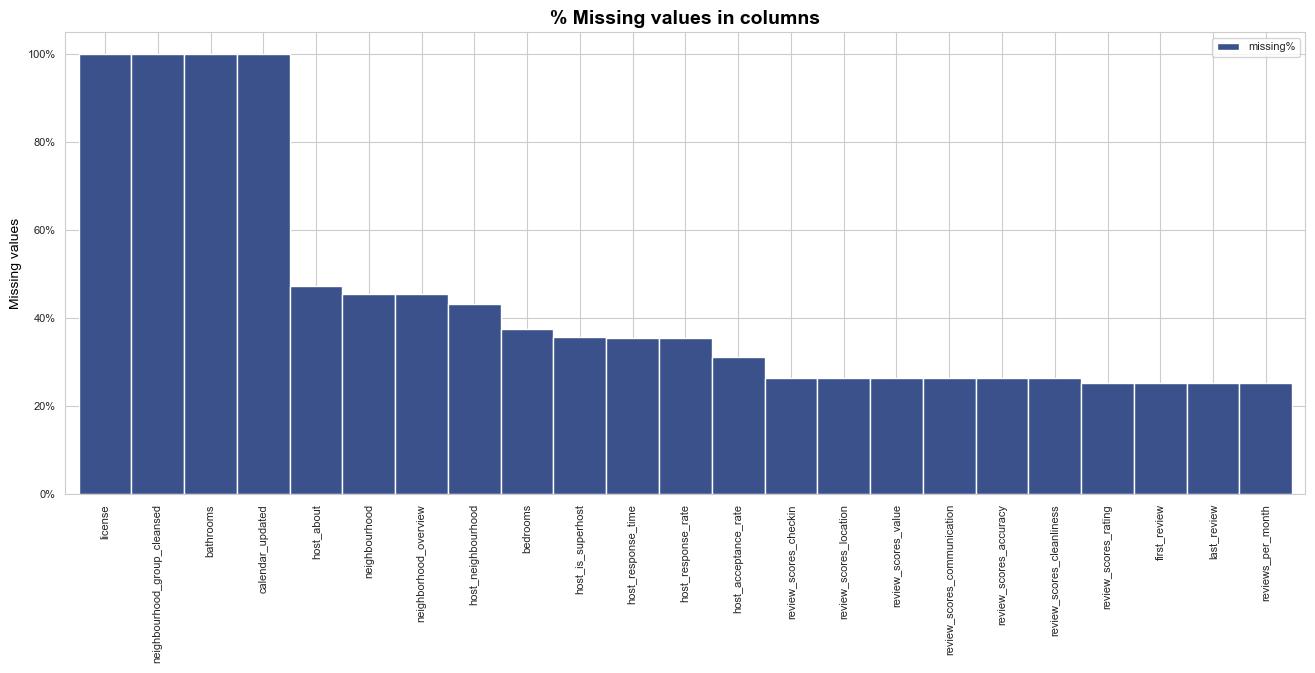

In [30]:
# plot columns with missing values > 25%
missing_columns = round(listing.isna().mean() * 100, 2).sort_values(ascending=False)
missing_columns = missing_columns[missing_columns > 25]
df_missing_values = pd.DataFrame(missing_columns,
                                        columns=['missing%'],
                                        index=missing_columns.index)

df_missing_values.plot(kind="bar",
                           figsize=(16, 6),
                           title='% Missing values',
                           width=1,
                           color=BASE_COLOR)


yticks = np.arange(0, 101, 20)
ylabels = ['{}%'.format(v) for v in yticks]
plt.ylabel('Missing values')
plt.title('% Missing values in columns')
plt.yticks(yticks, ylabels)
plt.xlabel = 'Features'
plt.title('% Missing values in columns', fontsize=14)
plt.show()

**Observations:**
   - some columns contain 100% missing values and are thus meaningless
   - columns `host_about` and `neighbourhood` contains long free text descriptions and are missing more than 40%

#### Missing data in rows

In [31]:
missing_data_in_rows = listing.isna().mean(axis=1) * 100

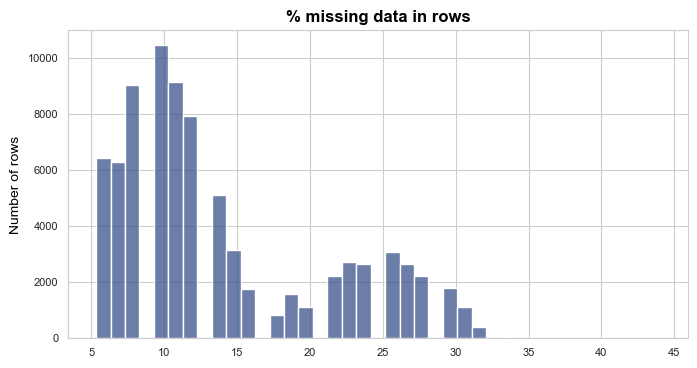

In [32]:
sns.histplot(missing_data_in_rows, binwidth=1, color=BASE_COLOR)
plt.title('% missing data in rows')
plt.ylabel('Number of rows')
plt.show()

In [33]:
# missing value percentiles
missing_data_in_rows.describe([0.25, 0.5, 0.75, 0.85, 0.9, 0.95, 0.99])

count   81791
mean       14
std         7
min         5
25%         8
50%        11
75%        19
85%        24
90%        27
95%        28
99%        31
max        44
dtype: float64

In [34]:
# Investigate deeper the rows with missing values > 30%
missing_rows = missing_data_in_rows.loc[(missing_data_in_rows > 30)]
print('missing rows {}'.format(len(missing_rows)))
listing.loc[missing_rows.index].sample(5)

missing rows 1598


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
52700,612865227541390662,https://www.airbnb.com/rooms/612865227541390662,20230608145305,2023-06-09,city scrape,Home in Greater London · 1 bedroom · 1 bed · 1...,Relax with the family at this peaceful place t...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,451497198,https://www.airbnb.com/users/show/451497198,Gabriel,2022-03-27,NaN,NaN,NaN,NaN,67%,NaN,https://a0.muscache.com/defaults/user_pic-50x5...,https://a0.muscache.com/defaults/user_pic-225x...,NaN,3,4,"['email', 'phone']",f,t,NaN,Croydon,NaN,51,-0,Private room in home,Private room,2,NaN,1 shared bath,NaN,1,"[""Freezer"", ""Oven"", ""Free parking on premises""...",$300.00,4,21,4,4,1125,1125,4,1125,NaN,t,30,60,90,365,2023-06-09,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,2,0,2,0,NaN
48066,52774010,https://www.airbnb.com/rooms/52774010,20230608145305,2023-06-09,city scrape,Condo in Greater London · 2 bedrooms · 2 beds ...,Set over two floors of an Edwardian terraced h...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,34920997,https://www.airbnb.com/users/show/34920997,Tomas,2015-06-03,"London, United Kingdom",NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/user/39b20...,https://a0.muscache.com/im/pictures/user/39b20...,NaN,1,1,"['email', 'phone']",t,t,NaN,Haringey,NaN,52,-0,Private room in condo,Private room,4,NaN,2 baths,NaN,2,"[""TV"", ""Wifi"", ""Hot water"", ""Iron"", ""Dedicated...",$220.00,3,14,3,3,14,14,3,14,NaN,t,0,0,0,38,2023-06-09,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,1,0,1,0,NaN
41335,43890551,https://www.airbnb.com/rooms/43890551,20230608145305,2023-06-08,city scrape,Rental unit in Burnt Oak · 1 bedroom · 1 priva...,"Located in Edgware, 2.3 km from Royal Air Forc...",NaN,https://a0.muscache.com/pictures/25347456-95d8...,351323536,https://www.airbnb.com/users/show/351323536,Katherine,2020-06-22,NaN,NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/user/aba17...,https://a0.muscache.com/im/pictures/user/aba17...,NaN,1,1,['phone'],t,f,NaN,Barnet,NaN,52,-0,Private room in rental unit,Private room,2,NaN,1 private bath,NaN,NaN,"[""TV"", ""Wifi"", ""Lock on bedroom door"", ""Smoke ...",$631.00,1,1125,1,1,1125,1125,1,1125,NaN,t,30,60,90,91,2023-06-08,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,1,0,1,0,NaN
61584,733944238705295598,https://www.airbnb.com/rooms/733944238705295598,20230608145305,2023-06-09,city scrape,Home in Greater London · 1 bedroom · 1 bed · 1...,Bring the whole family to this great place wit...,NaN,https://a0.muscache.com/pictures/f1f77517-6f38...,201020957,https://www.airbnb.com/users/show/201020957,Anna,2018-07-09,"England, United Kingdom",NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/user/acee4.

>**Observations:** 
>- Rows with missing data exceeding 30%, are listings that have never been reviewed and/or have missing host data

In [35]:
##### Explore missing values with missingno

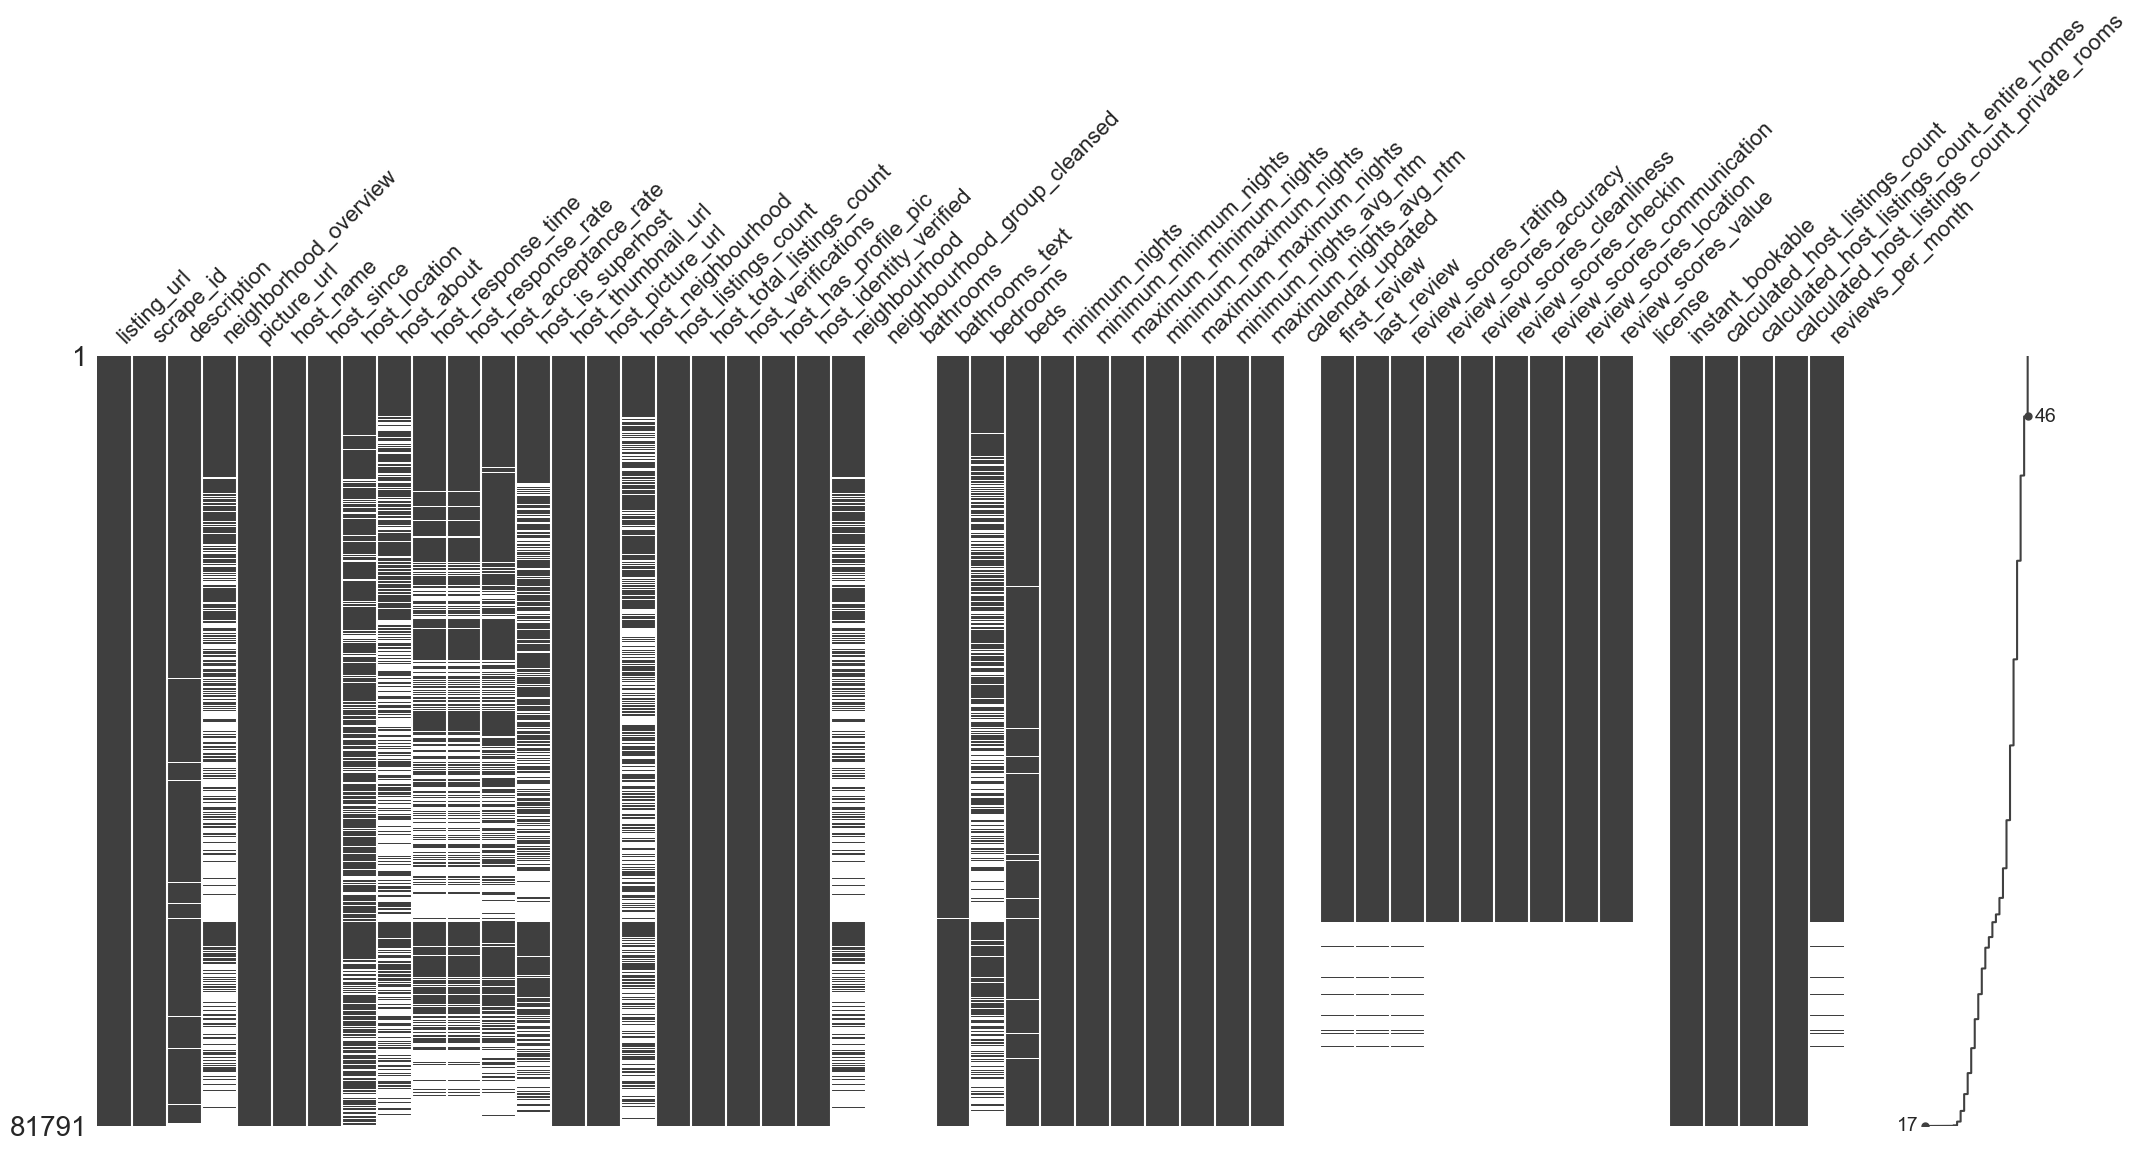

In [36]:
# Where in the dataset do missing values appear? Are there relationships between missing data in columns ?
msno.matrix(listing, filter="bottom", n=50, sort="descending");

>**Observations**:
>- There are 4 columns that have **all values missing** (neighborhood, bathrooms, calendar_updated and license)
>- There are 10 columns related to **host information** that have lots of missing values, and it seems like lots of relationships could exist between those host columns, if one value is missing others are most likely missing as well
>- **Bedrooms** have a lot of missing values, whilst **beds** are well populated
>- Towards the end of the file, there are 10 columns related to **reviews** with lots of missing values with a clear relationship. If one of these columns are missing, all columns is missing.

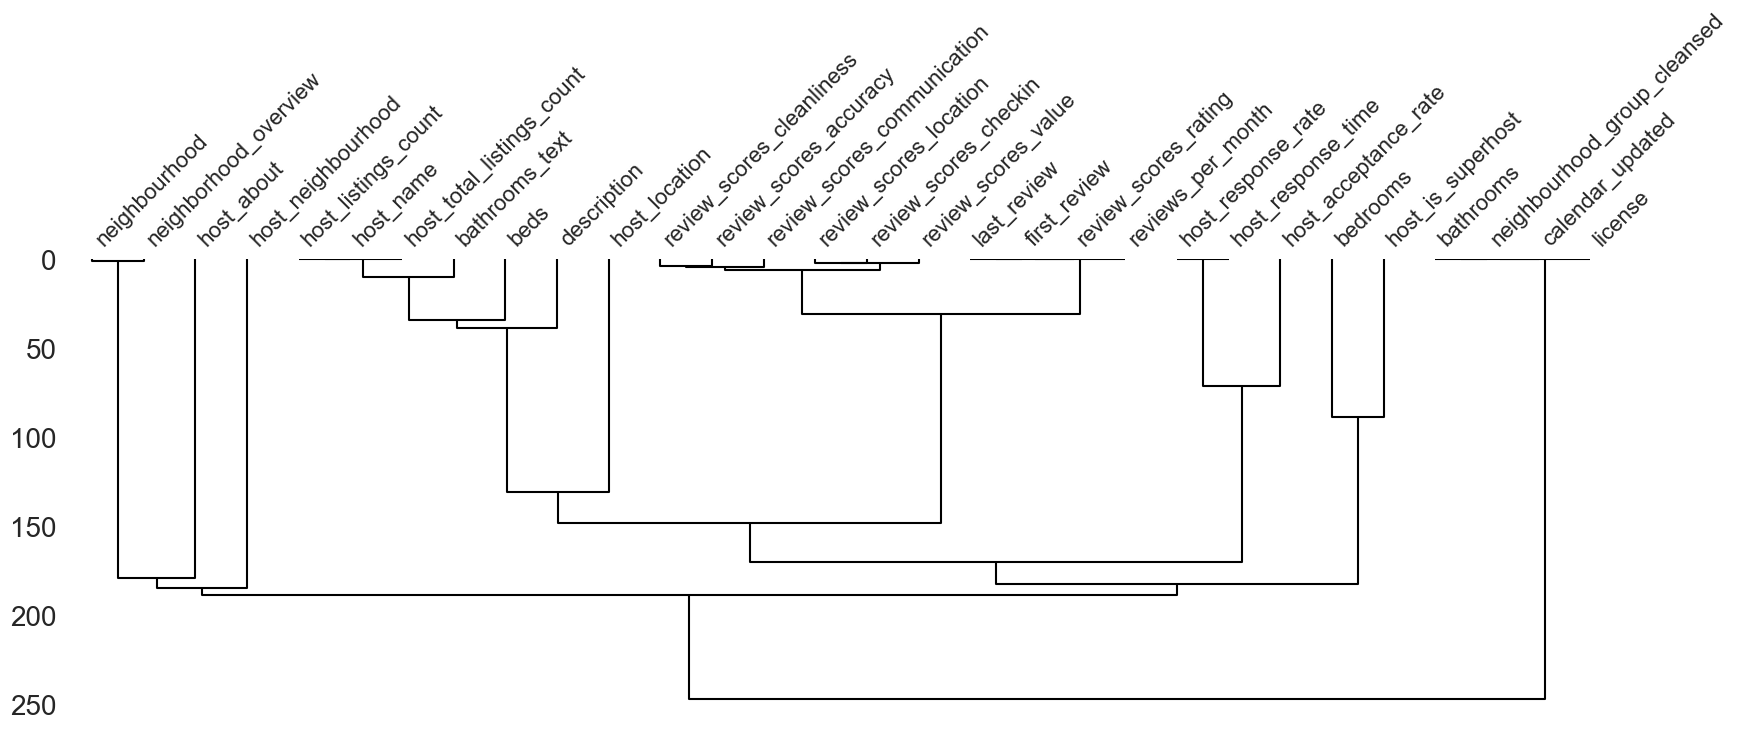

In [37]:
# Investigate deeper the relationships in the amount of missing data in each column
# The top line shows the highest relationships and correlations
msno.dendrogram(listing, filter="bottom", n=30, figsize=(20,6));

>**Observations**:
>- When host response_rate is missing, host_response_time and host_acceptance_rate are also missing
>- If review_scores_rating is missing, the sub categories for reviews are also missing
>- If superhost is missing, number of bedrooms are probably missing as well
>- Looks like superhost describes their properties better ?

#### Lets take a deeper look at missing values in reviews and its relationships

In [38]:
review_cols = ['first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
              'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value',
              'reviews_per_month']

In [39]:
listing[review_cols].head()

,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
0,2016-01-12,2016-01-12,5,5,5,5,5,5,5,0
1,2011-07-13,2023-05-02,5,5,5,5,5,5,5,1
2,2010-08-18,2022-12-11,5,5,5,5,5,5,5,0
3,2009-12-21,2023-05-01,5,5,5,5,5,5,5,1
4,2016-12-18,2017-05-31,4,5,4,4,5,5,5,0


In [40]:
# missing values for reviews was mostly present at the end of the file
listing[review_cols].tail()

,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
81786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81788,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81790,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
# inspect a record with missing review columns
listing.iloc[81786]

id                                                                             908448542533162051
listing_url                                       https://www.airbnb.com/rooms/908448542533162051
scrape_id                                                                          20230608145305
last_scraped                                                                           2023-06-10
source                                                                                city scrape
name                                            Rental unit in Greater London · ★New · 1 bedro...
description                                     Show up and start living from day one in Londo...
neighborhood_overview                           With leafy, green pathways and large, lavish m...
picture_url                                     https://a0.muscache.com/pictures/prohost-api/H...
host_id                                                                                 314162972
host_url            

>**Observation**
>- If `number_of_reviews` = 0, all the review fields are missing
>- This is long term rental with minimum rental days = 90 days. It's more a commercial listing than short term holiday rental

In [42]:
# are the review fields only missing when number of reviews = 0?
listing[(listing.number_of_reviews > 0) & (listing.review_scores_rating.isna())].any().any()

False

In [43]:
#### Lets take a deeper look at missing values in features describing the host

In [44]:
host_columns = ['host_url', 'host_name', 'host_since', 'host_location', 'host_about', 
                'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 
                'host_picture_url', 'host_thumbnail_url', 'host_neighbourhood', 'host_listings_count', 
                'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 
                'number_of_reviews', 'availability_365']

In [45]:
listing[host_columns].head()

,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_picture_url,host_thumbnail_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,number_of_reviews,availability_365
0,https://www.airbnb.com/users/show/211018,Sylvia,2010-08-24,"Rome, Italy",i love to travel and therefor want to give my ...,NaN,NaN,NaN,f,https://a0.muscache.com/im/users/211018/profil...,https://a0.muscache.com/im/users/211018/profil...,Pimlico,1,5,"['email', 'phone']",t,f,1,0
1,https://www.airbnb.com/users/show/757377,Eilinn,2011-06-29,"London, United Kingdom","Eilinn, Yoon our daughters Surei and Sukyi wou...",within a few hours,90%,68%,NaN,https://a0.muscache.com/im/users/757377/profil...,https://a0.muscache.com/im/users/757377/profil...,Hammersmith,1,2,"['email', 'phone']",t,t,175,67
2,https://www.airbnb.com/users/show/54730,Alina,2009-11-16,"London, United Kingdom",I am a Multi-Media Visual Artist and Creative ...,within an hour,100%,78%,NaN,https://a0.muscache.com/im/users/54730/profile...,https://a0.muscache.com/im/users/54730/profile...,LB of Islington,3,4,"['email', 'phone']",t,t,41,353
3,https://www.airbnb.com/users/show/60302,Philippa,2009-12-05,"Royal Borough of Kensington and Chelsea, Unite...","English, grandmother, I have travelled quite ...",within a day,100%,47%,f,https://a0.muscache.com/im/users/60302/profile...,https://a0.muscache.com/im/users/60302/profile...,Chelsea,1,12,"['email', 'phone']",t,t,94,70
4,https://www.airbnb.com/users/show/1573870,Robert,2012-01-06,"London, United Kingdom","Hi my name is Rob,\r\n\r\nI am a software deve...",within a day,100%,100%,f,https://a0.muscache.com/im/users/1573870/profi...,https://a0.muscache.com/im/users/1573870/profi...,Shoreditch,1,3,"['email', 'phone']",t,t,20,4


In [46]:
# It's strange that host_response_rate is not filled sometimes
listing[listing['host_response_rate'].isna()][:20]

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,154221,https://www.airbnb.com/rooms/154221,20230608145305,2023-06-10,previous scrape,Rental unit in London · 2 bedrooms · 2 beds · ...,"hi, i am renting my 2 bedroom flat in Pimlico ...","a very save area of central London , Pimlico i...",https://a0.muscache.com/pictures/3510524/72655...,211018,https://www.airbnb.com/users/show/211018,Sylvia,2010-08-24,"Rome, Italy",i love to travel and therefor want to give my ...,NaN,NaN,NaN,f,https://a0.muscache.com/im/users/211018/profil...,https://a0.muscache.com/im/users/211018/profil...,Pimlico,1,5,"['email', 'phone']",t,f,"London, England, United Kingdom",Westminster,NaN,51,-0,Entire rental unit,Entire home/apt,3,NaN,1 bath,2,2,"[""TV"", ""Microwave"", ""Dishwasher"", ""Wifi"", ""Ref...",$83.00,2,30,2,2,30,30,2,30,NaN,t,0,0,0,0,2023-06-10,1,0,0,2016-01-12,2016-01-12,5,5,5,5,5,5,5,NaN,f,1,1,0,0,0
6,306405,https://www.airbnb.com/rooms/306405,20230608145305,2023-06-08,city scrape,Rental unit in Dagenham · ★4.0 · 1 bedroom · 1...,<b>The space</b><br />It is suitable for solo ...,NaN,https://a0.muscache.com/pictures/4070359/6d80d...,1575800,https://www.airbnb.com/users/show/1575800,Mary,2012-01-06,"London, United Kingdom",Hi my name is ruby,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/users/1575800/profi...,https://a0.muscache.com/im/users/1575800/profi...,LB of Barking and Dagenham,1,1,"['email', 'phone']",t,f,NaN,Barking and Dagenham,NaN,52,0,Private room in rental unit,Private room,1,NaN,0 baths,NaN,1,"[""Wifi"", ""Washer"", ""Heating"", ""Kitchen"", ""TV w...",$41.00,4,365,4,4,365,365,4,365,NaN,t,30,60,90,365,2023-06-08,3,0,0,2012-02-21,2012-05-27,4,4,4,4,3,3,4,NaN,f,1,0,1,0,0
7,306677,https://www.airbnb.com/rooms/306677,20230608145305,2023-06-10,previous scrape,Rental unit in London · ★4.56 · 2 bedrooms · 3...,Non smoking apartment worth uk£600k (US$900k) ...,Fantastic location to access all tourist attra...,https://a0.muscache.com/pictures/3419083/e5533...,1577254,https://www.airbnb.com/users/show/1577254,Pm,2012-01-07,"London, United Kingdom",Live life travel see the world,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/74e33...,https://a0.muscache.com/im/pictures/user/74e33...,Southwark,8,14,"['email', 'phone']",t,t,"London, United Kingdom",Southwark,NaN,51,-0,Entire rental unit,Entire home/apt,5,NaN,1 bath,2,3,"[""TV"", ""Elevator"", ""Wifi"", ""Hot water"", ""Iron""...",$132.00,5,90,5,5,1125,1125,5,1125,NaN,t,0,0,0,0,2023-06-10,218,0,0,2012-02-06,2020-02-29,5,5,5,5,5,4,5,NaN,t,6,6,0,0,2
11,168359,https://www.airbnb.com/rooms/168359,20230608145305,2023-06-10,previous scrape,Rental unit in Greater London · ★4.63 · 2 bedr...,This 2 bedroom flat is in a brilliantly conven...,Wal

**Observations**:
- `has_availability` is sometimes true, but the availability for next 365 days = 0
- host_since is a date field not a string
- host is hosting a long time, but in last year no reviews and availabily next 365 years sometimes 0. Could it be that hosts took the property off the market, and the response rate fields are missing due to this ?

#### Can we identify possible inactive properties ?

In [47]:
# extract what we think could be inactive properties, no availability and reviews 
inactive_test = listing[(listing['has_availability'] == 't') & 
                        (listing['availability_365'] == 0) & 
                        (listing['number_of_reviews_ltm'] == 0)]
inactive_test.sample(10)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
3019,4163054,https://www.airbnb.com/rooms/4163054,20230608145305,2023-06-10,previous scrape,Rental unit in London · 1 bedroom · 1 bed · 1 ...,Bright and spacious double bedroom in a stunni...,Calm and leafy neighbourhood<br />Some nice re...,https://a0.muscache.com/pictures/52337687/efea...,21605556,https://www.airbnb.com/users/show/21605556,Charles,2014-09-21,"London, United Kingdom",French guy working in London (yet another one ...,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/users/21605556/prof...,https://a0.muscache.com/im/users/21605556/prof...,Hampstead,1,1,"['email', 'phone']",t,t,"London, United Kingdom",Camden,NaN,52,-0,Private room in rental unit,Private room,1,NaN,1 bath,NaN,1,"[""TV"", ""Wifi"", ""Washer"", ""Smoke alarm"", ""Heati...",$40.00,1,1125,1,1,1125,1125,1,1125,NaN,t,0,0,0,0,2023-06-10,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,1,0,1,0,NaN
11045,13013842,https://www.airbnb.com/rooms/13013842,20230608145305,2023-06-10,previous scrape,Rental unit in London · ★4.0 · 2 bedrooms · 2 ...,Spacious and comfortable 2 bedroom flat in a c...,Welcome to the home of the famous. Notable res...,https://a0.muscache.com/pictures/537f5307-2bc8...,10070470,https://www.airbnb.com/users/show/10070470,Rezwan,2013-11-17,"London, United Kingdom",NaN,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/b7440...,https://a0.muscache.com/im/pictures/user/b7440...,Hampstead,1,1,"['email', 'phone', 'work_email']",t,t,"London, United Kingdom",Camden,NaN,52,-0,Entire rental unit,Entire home/apt,4,NaN,1 bath,2,2,"[""Wifi"", ""Iron"", ""Pets allowed"", ""Washer"", ""Ha...",$120.00,1,1125,1,2,1125,1125,1,1125,NaN,t,0,0,0,0,2023-06-10,5,0,0,2016-07-16,2016-08-28,4,4,4,4,4,4,4,NaN,f,1,1,0,0,0
9854,11684887,https://www.airbnb.com/rooms/11684887,20230608145305,2023-06-10,previous scrape,Rental unit in London · 3 bedrooms · 2 beds · ...,"Light, airy and spacious, this flat is perfect...",Our area is very family friendly and the beaut...,https://a0.muscache.com/pictures/af7c4da5-bc4a...,2064085,https://www.airbnb.com/users/show/2064085,Claire,2012-04-03,"Brighton, United Kingdom","We are an Anglo-American family, part American...",NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/5d0b8...,https://a0.muscache.com/im/pictures/user/5d0b8...,LB of Brent,3,3,"['email', 'phone']",t,f,"London, United Kingdom",Brent,NaN,52,-0,Entire rental unit,Entire home/apt,5,NaN,2 baths,3,2,"[""TV"", ""Wifi"", ""Iron"", ""Washer"", ""Hangers"", ""H...",$98.00,3,1125,3,3,1125,1125,3,1125,NaN,t,0,0,0,0,2023-06-10,2,0,0,2016-07-12,2017-07-07,5,5,5,5,5,3,4,NaN,f,2,1,1,0,0
17789,19080420,https://www.airbnb.com/rooms/19080420,20230608145305,2023-06-10,previous scr

>**Observation**
>- There definetely seem to be quite a lot of properties in the dataset that seems inactive, it looks like the host are not longer renting them out

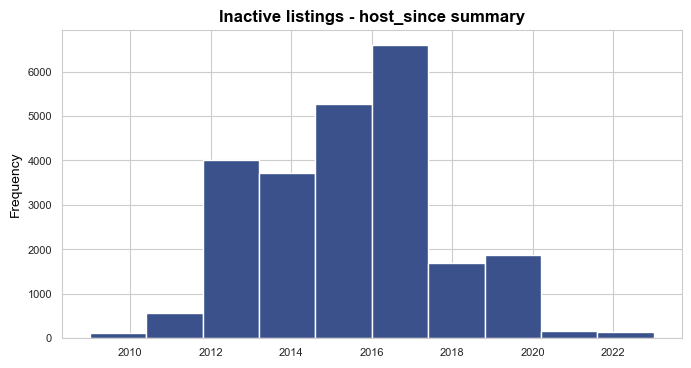

In [48]:
# since when was inactive listings on the market ?
inactive_test.host_since.str[:4].astype(float).plot(kind='hist', bins=10, color=BASE_COLOR)
plt.title('Inactive listings - host_since summary')
plt.show()

In [49]:
# minimum rental nights for 'inactive' records
inactive_test.minimum_nights_avg_ntm.describe()

count   24166
mean        5
std        24
min         1
25%         1
50%         2
75%         4
max      1125
Name: minimum_nights_avg_ntm, dtype: float64

In [50]:
# how many properties does hosts have ?
inactive_test.host_listings_count.describe()

count   24162
mean       20
std       165
min         1
25%         1
50%         1
75%         2
max      2747
Name: host_listings_count, dtype: float64

In [51]:
# how many total properties does hosts have ?
inactive_test.host_total_listings_count.describe()

count   24162
mean       33
std       283
min         1
25%         1
50%         1
75%         3
max      4724
Name: host_total_listings_count, dtype: float64

In [52]:
# display an 'inactive' listing that was introduced only in the current year
inactive_test[inactive_test.host_since == '2023-03-09']

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
72042,843945826445757806,https://www.airbnb.com/rooms/843945826445757806,20230608145305,2023-06-10,previous scrape,Home in Greater London · 3 bedrooms · 3 beds ·...,Beautiful period house next to London fields a...,London fields park is just around the corner a...,https://a0.muscache.com/pictures/miso/Hosting-...,504659671,https://www.airbnb.com/users/show/504659671,Petros,2023-03-09,"London, United Kingdom","Hello am Petros , I live by London fields for ...",NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/1fde6...,https://a0.muscache.com/im/pictures/user/1fde6...,NaN,1,1,"['email', 'phone']",t,t,"Greater London, England, United Kingdom",Hackney,NaN,52,-0,Entire home,Entire home/apt,6,NaN,2 baths,3,3,"[""Freezer"", ""Oven"", ""Hot water"", ""Paid parking...",$350.00,3,365,3,3,365,365,3,365,NaN,t,0,0,0,0,2023-06-10,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,1,1,0,0,NaN


**Observation**:

*Think about it...*

If a property is really so popular that it's booked out for the whole year ahead, there would be lots of active reviews present.
I think it's save assume if no availability and no reviews, when we had lots of reviews in the past, we can assume the listing is no longer on the market. It introduces lots of missing values, and could contain prices no longer matching to the current market.

BUT be careful to remove long term rentals as then it make sense no availability, no reviews....

Think about only removing where number of listing = 1 (private person), and minimum nights < 4 nights

I think these records should be dropped instead, but only do this when host_since is in the past

In [53]:
# updated rule - how many listings are affected
inactive_test_2 = listing[(listing['has_availability'] == 't') & 
                          (listing['availability_365'] == 0) & 
                          (listing['number_of_reviews_ltm'] == 0) &
                          (listing['host_listings_count'] <= 3) &
                          (listing['minimum_nights_avg_ntm'] <= 30)]
len(inactive_test_2)

21350

In [54]:
inactive_test_2.sample(5)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
37097,39168336,https://www.airbnb.com/rooms/39168336,20230608145305,2023-06-09,previous scrape,Rental unit in Greater London · 1 bedroom · 1 ...,A lovely lower ground floor flat in Finchley C...,Finchley Central is a lovely part of North Lon...,https://a0.muscache.com/pictures/fa739757-b1e7...,300475120,https://www.airbnb.com/users/show/300475120,Rebecca,2019-10-06,NaN,NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/user/b3646...,https://a0.muscache.com/im/pictures/user/b3646...,LB of Barnet,1,1,"['email', 'phone']",t,f,"Greater London, England, United Kingdom",Barnet,NaN,52,-0,Private room in rental unit,Private room,4,NaN,1.5 baths,NaN,1,"[""Free parking on premises"", ""Wifi"", ""Hot wate...",$60.00,2,1125,2,2,1125,1125,2,1125,NaN,t,0,0,0,0,2023-06-09,1,0,0,2019-10-27,2019-10-27,5,3,5,5,5,5,5,NaN,t,1,0,1,0,0
19918,20712453,https://www.airbnb.com/rooms/20712453,20230608145305,2023-06-10,previous scrape,Home in London · 3 bedrooms · 3 beds · 2 share...,The property is situated over three floors of ...,NaN,https://a0.muscache.com/pictures/ecd2d6c3-5217...,42415982,https://www.airbnb.com/users/show/42415982,Linna,2015-08-24,"England, United Kingdom",NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/users/42415982/prof...,https://a0.muscache.com/im/users/42415982/prof...,NaN,1,1,"['email', 'phone']",t,t,NaN,Wandsworth,NaN,51,-0,Private room in home,Private room,6,NaN,2 shared baths,NaN,3,"[""Wifi"", ""Iron"", ""Washer"", ""Hangers"", ""Smoke a...",$119.00,3,1125,3,3,1125,1125,3,1125,NaN,t,0,0,0,0,2023-06-10,1,0,0,2018-04-01,2018-04-01,5,5,5,5,5,5,5,NaN,f,1,0,1,0,0
18423,19631200,https://www.airbnb.com/rooms/19631200,20230608145305,2023-06-10,previous scrape,Rental unit in Greater London · ★4.50 · 1 bedr...,One double bedroom of good size and great cond...,Saint John's Wood is a district of northwest L...,https://a0.muscache.com/pictures/7516a7c0-6685...,4692718,https://www.airbnb.com/users/show/4692718,Maria,2013-01-13,"Madrid, Spain",NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/users/4692718/profi...,https://a0.muscache.com/im/users/4692718/profi...,St. John's Wood,1,1,"['email', 'phone', 'work_email']",t,t,"Greater London, England, United Kingdom",Westminster,NaN,52,-0,Private room in rental unit,Private room,2,NaN,1 shared bath,NaN,1,"[""Elevator"", ""Wifi"", ""Iron"", ""Washer"", ""Hanger...",$36.00,2,1125,2,2,1125,1125,2,1125,NaN,t,0,0,0,0,2023-06-10,7,0,0,2017-07-08,2017-07-30,4,4,4,5,5,4,4,NaN,t,1,0,1,0,0
11815,13629555,https://www.airbnb.com/rooms/13629555,20230608145305,2023-06-10,previous scrape,Home in London · 3 bedrooms · 3 beds · 2 baths,"Beautiful, recently renovated house. Only look...",NaN,https://a0.musca

#### Inspect how the daily price in the listing dataset correspond to the price in calendar dataset. Is listing price the mean daily price from calendar?

In [55]:
# first make a temp copy
calendar_tmp = calendar[['listing_id', 'price']].copy()
listing_tmp = listing[['id', 'price']].copy()

# convert price to numeric field so we can compare the datasets
calendar_tmp['calendar_price'] = calendar_tmp['price'].str.replace('[%$,]','', regex=True).astype('float32', copy=True)
calendar_tmp.drop(['price'], axis=1, inplace=True)

listing_tmp['listing_price'] = listing_tmp['price'].str.replace('[%$,]','', regex=True).astype('float32', copy=True)
listing_tmp.drop(['price'], axis=1, inplace=True)

listing_tmp.rename(columns={'id':'listing_id'}, inplace=True)

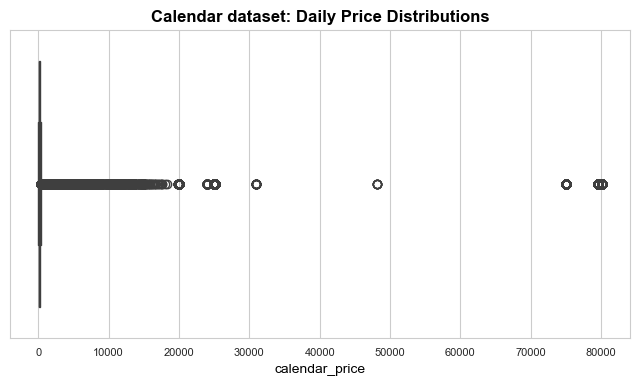

In [56]:
sns.boxplot(data=calendar_tmp, x='calendar_price')
plt.title('Calendar dataset: Daily Price Distributions')
plt.show()

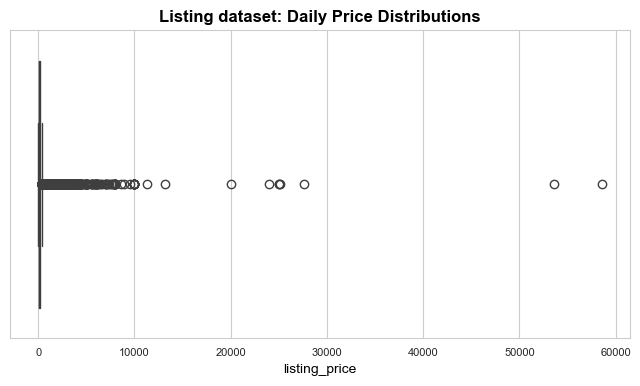

In [57]:
sns.boxplot(data=listing_tmp, x='listing_price')
plt.title('Listing dataset: Daily Price Distributions')
plt.show()

>**Observation:** Accessive daily prices over 10k exist, which deserves a deeper look

In [58]:
df_prices = listing_tmp.merge(calendar_tmp, on='listing_id', how='inner')
df_prices.describe([0.25, 0.5, 0.75, 0.90, 0.99])

,listing_id,listing_price,calendar_price
count,29853019,29853019,29851926
mean,297408626308369920,188,202
std,379219973567459328,477,527
min,13913,0,0
25%,21053002,61,65
50%,43120044,110,115
75%,729314415948940032,198,205
90%,855689759798287488,343,388
99%,904294036616160768,1570,1570
max,909281506879757696,58564,80100


>**Observation:** Huge maximum prices over 50k exist at 99 percentile ! Look suspisious...

In [59]:
# display listings with biggest difference between base rate in listing vs mean price from calendar dataset
calendar_grouped = df_prices.groupby('listing_id', as_index=False).agg({'listing_price':'mean', 
                                                                        'calendar_price':'mean'})
calendar_grouped['diff'] = abs(calendar_grouped['calendar_price'] - calendar_grouped['listing_price'])
calendar_grouped.sort_values('diff', ascending=False, inplace=True)
calendar_grouped.head()

,listing_id,listing_price,calendar_price,diff
36566,38452677,100,28366,28266
55781,658361293784718707,27579,928,26651
47053,51839279,24000,5659,18341
41968,44696103,8583,711,7872
30675,31622680,7580,572,7008


In [60]:
calendar_grouped.describe([0.5, 0.8, 0.9,  0.99])

,listing_id,listing_price,calendar_price,diff
count,81790,81790,81790,81790
mean,297405367886428800,188,202,28
std,379221496924105152,477,470,194
min,13913,0,0,0
50%,43119658,110,115,1
80%,776578602927593856,225,250,20
90%,855688302867718528,343,393,56
99%,904293407003396864,1570,1570,429
max,909281506879757696,58564,58420,28266


In [61]:
# Number of properties where listing daily price != mean calendar price
len(calendar_grouped[calendar_grouped['diff'] > 100])

4834

In [62]:
# properties with biggest differences
calendar_grouped[:300]

,listing_id,listing_price,calendar_price,diff
36566,38452677,100,28366,28266
55781,658361293784718707,27579,928,26651
47053,51839279,24000,5659,18341
41968,44696103,8583,711,7872
30675,31622680,7580,572,7008
41988,44734906,7206,650,6556
79283,894034192184656301,2789,9047,6258
30684,31634469,6067,295,5772
450,450460,5565,391,5174
11042,13050998,6073,943,5130


In [63]:
# records where listing price is mean calendar price, as expected
calendar_grouped.tail(10)

,listing_id,listing_price,calendar_price,diff
33081,34604619,330,330,0
33082,34605872,100,100,0
33083,34608588,185,185,0
33088,34618194,170,170,0
33093,34622090,776,776,0
33094,34622125,916,916,0
33095,34622145,846,846,0
33097,34622998,120,120,0
33100,34624383,180,180,0
81789,909281506879757665,135,135,0


In [64]:
listing[listing.id == 658361293784718707]

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
55761,658361293784718707,https://www.airbnb.com/rooms/658361293784718707,20230608145305,2023-06-09,city scrape,Home in Greater London · 2 bedrooms · 4 beds ·...,This unique place has a style all of its own.<...,NaN,https://a0.muscache.com/pictures/26784fb9-b85b...,149053970,https://www.airbnb.com/users/show/149053970,Julie,2017-09-04,"London, United Kingdom",Professional,within a few hours,100%,84%,NaN,https://a0.muscache.com/im/pictures/user/e95fd...,https://a0.muscache.com/im/pictures/user/e95fd...,LB of Redbridge,13,16,"['email', 'phone']",t,t,NaN,Redbridge,NaN,52,0,Private room in home,Private room,7,NaN,1.5 shared baths,2,4,"[""Freezer"", ""Oven"", ""Hot water"", ""Washer"", ""Ex...","$27,579.00",1,365,1,1,365,365,1,365,NaN,t,1,2,2,224,2023-06-09,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,3,0,3,0,NaN


>**Observation**: There are listings in the calendar dataset where prices increase significantly from one day to the next, distorting the average daily base price in the listings dataset

#### Understand the difference between host_listings_count, host_total_listings_count and calculated_host_listings_count

In [65]:
listing.loc[listing['calculated_host_listings_count'] > 5, ['id', 'host_id', 'host_listings_count', 'host_total_listings_count', 'calculated_host_listings_count']][:5]

,id,host_id,host_listings_count,host_total_listings_count,calculated_host_listings_count
7,306677,1577254,8,14,6
8,17402,67564,10,32,9
18,308005,67564,10,32,9
57,203163,460272,9,12,9
76,47687,216660,12,12,12


In [66]:
listing[listing.host_id == 1577254]

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
7,306677,https://www.airbnb.com/rooms/306677,20230608145305,2023-06-10,previous scrape,Rental unit in London · ★4.56 · 2 bedrooms · 3...,Non smoking apartment worth uk£600k (US$900k) ...,Fantastic location to access all tourist attra...,https://a0.muscache.com/pictures/3419083/e5533...,1577254,https://www.airbnb.com/users/show/1577254,Pm,2012-01-07,"London, United Kingdom",Live life travel see the world,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/74e33...,https://a0.muscache.com/im/pictures/user/74e33...,Southwark,8,14,"['email', 'phone']",t,t,"London, United Kingdom",Southwark,NaN,51,-0,Entire rental unit,Entire home/apt,5,NaN,1 bath,2,3,"[""TV"", ""Elevator"", ""Wifi"", ""Hot water"", ""Iron""...",$132.00,5,90,5,5,1125,1125,5,1125,NaN,t,0,0,0,0,2023-06-10,218,0,0,2012-02-06,2020-02-29,5,5,5,5,5,4,5,NaN,t,6,6,0,0,2
1628,1538921,https://www.airbnb.com/rooms/1538921,20230608145305,2023-06-10,previous scrape,Rental unit in London · ★4.52 · 2 bedrooms · 3...,Non smoking apartment worth uk£600k (US$900k) ...,Fantastic location to access all tourist attra...,https://a0.muscache.com/pictures/22533617/d371...,1577254,https://www.airbnb.com/users/show/1577254,Pm,2012-01-07,"London, United Kingdom",Live life travel see the world,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/74e33...,https://a0.muscache.com/im/pictures/user/74e33...,Southwark,8,14,"['email', 'phone']",t,t,"London, United Kingdom",Southwark,NaN,51,-0,Entire rental unit,Entire home/apt,5,NaN,1 bath,2,3,"[""TV"", ""Elevator"", ""Wifi"", ""Hot water"", ""Bed l...",$127.00,5,1124,5,5,1124,1124,5,1124,NaN,t,0,0,0,0,2023-06-10,52,0,0,2013-12-25,2019-08-18,5,5,5,5,5,5,5,NaN,t,6,6,0,0,0
2147,2635019,https://www.airbnb.com/rooms/2635019,20230608145305,2023-06-10,previous scrape,Rental unit in London · ★4.42 · 2 bedrooms · 2...,non smoking apartment worth UK £570k (US$860k)...,I love the fact that you are a short undergrou...,https://a0.muscache.com/pictures/50829555/17ae...,1577254,https://www.airbnb.com/users/show/1577254,Pm,2012-01-07,"London, United Kingdom",Live life travel see the world,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/74e33...,https://a0.muscache.com/im/pictures/user/74e33...,Southwark,8,14,"['email', 'phone']",t,t,"London, United Kingdom",Southwark,NaN,51,-0,Entire rental unit,Entire home/apt,5,NaN,1 bath,2,2,"[""TV"", ""Elevator"", ""Wifi"", ""Hot water"", ""Iron""...",$139.00,5,1125,5,5,1125,1125,5,1125,NaN,t,0,0,0,0,2023-06-10,119,0,0,2014-08-28,2020-01-02,4,5,4,5,5,4,4,NaN,t,6,6,0,0,1
14186,15900139,https://www.airbnb.com/rooms/15900139,20230608145305,2023-06-10,previous scrape,Rental unit in London · ★4.43 · 2 bedrooms · 3...,n

>**Observation**:

    - `calculated_host_listings_count are the number of times the 'host_id' appear in the dataset and seems reliable
    - `host_listings_count` and `host_total_listings_count` are much higher, it's unclear what is the meaning and should be dropped
    - 'host' characteristics are repeated for each listing, these fields could be extracted into a seperated host dataset

#### Display summary statistics

In [67]:
listing.describe([0.25, 0.5, 0.75, 0.9, 0.999]).T

,count,mean,std,min,25%,50%,75%,90%,99.9%,max
id,81791,297409117967533248,379220695235050432,13913,21053451,43120044,729314311194417408,855688140986544256,908466476136072832,909281506879757696
scrape_id,81791,20230608145305,0,20230608145305,20230608145305,20230608145305,20230608145305,20230608145305,20230608145305,20230608145305
host_id,81791,149160958,161130699,2594,21029247,74167394,247051464,447346991,517713894,518727604
host_listings_count,81786,43,261,1,1,2,6,37,2747,2747
host_total_listings_count,81786,77,472,1,1,3,10,57,4724,5225
neighbourhood_group_cleansed,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,81791,52,0,51,51,52,52,52,52,52
longitude,81791,-0,0,-0,-0,-0,-0,-0,0,0
accommodates,81791,3,2,0,2,2,4,6,16,16
bathrooms,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


>**Observations:**
>- Maximum number of nights have some crazy maximum values

### 2.3 Assessing `review` dataset

In [68]:
# visual inspection of reviews
review.sample(5)

,listing_id,id,date,reviewer_id,reviewer_name,comments
1260782,53618501,774560376013075377,2022-12-04,226196776,Manoj,"Clean, nice host and quick to respond!"
516489,15509284,131076883,2017-02-10,20912041,Martina,This is a beautiful flat a block away from the...
1282345,563010076634350425,640345288061496154,2022-06-02,16223205,Jean,I enjoy contemporary design so felt privileged...
1242012,52736237,601946674050801731,2022-04-10,450204944,Marie,This is a real mixed review… Antonio the host ...
643441,19320534,888242849743705852,2023-05-10,15455700,Matthew,Carlos was really helpful and communicative wi...


In [69]:
# does all listings have reviews ?
review.nunique()

listing_id         61190
id               1467496
date                4541
reviewer_id      1241267
reviewer_name     147325
comments         1409481
dtype: int64

In [70]:
# what is the maximum reviews per listing?
review.groupby('listing_id')['id'].count().sort_values(ascending=False)[:20]

listing_id
30760930    1425
19670926    1302
47408549    1202
43120947    1076
1436172     1004
2126708      896
1436177      844
3855375      817
45006692     811
21438138     808
42081759     782
2659707      774
46233904     771
14518189     743
5266466      742
4748665      733
9046849      711
2025844      697
42081840     680
5869526      668
Name: id, dtype: int64

**Observations**:
    
- Not all properties have ratings
- review dataset will not be used further for this project

<a id='clean'></a>
<span style="color:blue; font-size:25px; line-height:30px; font-family: Calibri;">Step 2: Cleaning</span>

<a id='sum_assessment'></a>
## Summary of assessment

Below is a summary of cleaning activities for dataset `listing` and `calendar`.  Only features of interest to answer above business questions will be cleaned. All other datasets and features not needed will be dropped or ignored.

### Quality issues
Do we have all the records that we should? Do we have missing records or not? Are there specific rows, columns, or cells missing?

<blockquote>    
    
#### [Completeness Issues (e.g. missing data)](#completeness)    

  
1. `bathroom` feature have all values missing, whilst the number of bathrooms are present in a text field `bathrooms_text`
1. `bedrooms` have 40% missing values, whilst the number of bedrooms are sometimes present in the `name` feature
1. `bedrooms` is missing if it is a studio, as studios normally have no bedrooms it's an open plan space
1. Some columns have all values missing
1. There are rows with over 30% missing values caused by missing review and/or host data 
1. There are listings in the dataset that seems inactive (not rented out anymore), causing a lot of missing values in rows
1. columns `host_about` and `neighborhood_overview` contains long free text descriptions and have missing values exceeding 40%   
<!-- 1. If `number_of_reviews` = 0, all other review fields are missing -->
   
<!-- 1. there are columns with > 20% missing values -->


#### [Validity Issues (incorrect entries, data types)](#validity)  

8. `host_since` is a date with type string
1. boolean fields have values 'f' and 't' (host_is_superhost, instant_bookable, has_availability, host_has_profile_pic, host_verified, instant_bookable)
1. `host_response_rate` and `host_acceptance_rate` and `price` are numeric fields as type string with prefix '%' or '$' present
1. calendar: `date` field is a date not a string
1. calendar: `available` is a boolean field with values 'f' and 't'    
1. convert float columns to integer (`host_total_listings_count`, `minimum_minimum_nights`, `minimum_maximum_nights`, `number_of_reviews`)
    
<!-- 1. `host_verifications` have multiple values (email, phone, etc)
1. 1% of listings have minimum stays > 90 days, which indicates long term rental for residential use  -->

    
#### [Consistency (e.g. same rules for data content full vs abbreviation) ](#consistency)     
14) `id` column in the `listing` should be called `listing_id` to be consistent with `calendar` table
    
#### [Accuracy (e.g. wrong data)](#accuracy)

15. There are listings in the calendar dataset where prices increase significantly from one day to the next, e.g. £100 one day, £24,000 the next
1. daily price in listings is not always the average mean price from the calendar dataset  
1. `minimum_maximum_nights` have some crazy maximum values > 90 mil !
    

</blockquote>    
 
 
### [Tidiness issues](#tidiness)

</blockquote> 

18. `bathroom_text` contains multiple pieces of information: number of baths and weather it's shared vs private
1. Drop unneeded variables
1. Optimize datatypes and memory
<!-- 1. `neighbourhood` column is a duplicate of `neighbourhood_cleansed` --> 
<!-- 1. `amenities` have multiple values -->  


</blockquote> 

In [71]:
# Make a copy of the original data
calendar_clean = calendar.copy() 
listing_clean = listing.copy() 

In [72]:
# clear the garbage to free memory
gc.collect()

30913

<a id='completeness'></a>
<span style="color:blue; font-size:20px; font-family: Calibri;">Completeness Issues</span>

<span style="color:blue; font-size:16px; font-family: Calibri;"> Issue #1: **bathroom**  feature have all values missing, whilst the number of bathrooms are present in a text field **bathrooms_text**</span>

**Define:** Extract first number from `bathroom_text` column using regex extract() method and store the result in feature `bathroom` as a float data type

#### Code

In [73]:
# visual inspection before
listing_clean[['bathrooms', 'bathrooms_text']][:10]

,bathrooms,bathrooms_text
0,NaN,1 bath
1,NaN,1.5 baths
2,NaN,1 shared bath
3,NaN,1 bath
4,NaN,1 bath
5,NaN,1 shared bath
6,NaN,0 baths
7,NaN,1 bath
8,NaN,2 baths
9,NaN,1 bath


In [74]:
# how many missing values does bathroom_text have ?
missing_entries = sum(listing_clean.bathrooms_text.isna())
print('bathrooms_text contain {} missing entries'.format(missing_entries))

bathrooms_text contain 102 missing entries


In [75]:
# convert bathroom text to lower case and replace text 'half-bath' with 0.5
listing_clean['bathrooms_text'] = listing_clean['bathrooms_text'].str.lower().str.replace('half-bath', '0.5')

In [76]:
# extract the numeric number of baths from the string
listing_clean['bathrooms'] = listing_clean['bathrooms_text'].str.extract(r"([-+]?\d*\.*\d+)")

In [77]:
pd.options.display.float_format = '{:,.1f}'.format
listing_clean['bathrooms'] = listing_clean['bathrooms'].astype('float')

#### Test

In [78]:
# visually inspection after
listing_clean[['bathrooms', 'bathrooms_text']][:10]

,bathrooms,bathrooms_text
0,1.0,1 bath
1,1.5,1.5 baths
2,1.0,1 shared bath
3,1.0,1 bath
4,1.0,1 bath
5,1.0,1 shared bath
6,0.0,0 baths
7,1.0,1 bath
8,2.0,2 baths
9,1.0,1 bath


In [79]:
listing_clean.bathrooms_text.value_counts()[:5]

bathrooms_text
1 bath            36300
1 shared bath     12062
2 baths            9838
1 private bath     6690
1.5 baths          6236
Name: count, dtype: int64

In [80]:
# number of entries with 1 bathroom matches the 3 records above containing 1 bathrooms
listing_clean.bathrooms.value_counts()

bathrooms
1.0     55052
2.0     11076
1.5      9596
2.5      2774
3.0      1435
3.5       702
4.0       251
0.5       222
0.0       191
4.5       148
5.0       126
5.5        36
6.0        21
6.5        15
12.0        9
7.0         6
7.5         5
9.0         4
23.0        3
8.5         3
8.0         3
10.5        2
12.5        2
10.0        2
17.0        1
13.0        1
22.0        1
50.0        1
9.5         1
Name: count, dtype: int64

In [81]:
# check that datatype is a float
assert listing_clean.bathrooms.dtype.name == 'float64'

In [82]:
# check that bathrooms now only a few missing values, same that is present in bathroom_text
assert sum(listing_clean.bathrooms.isna()) == missing_entries

<span style="color:blue; font-size:16px; font-family: Calibri;">Issue #2: **bedrooms** have 40% missing values, whilst the number of bedrooms are sometimes present in **name** feature**</span>

**Define**: Extract the float number infront of strings containing 'bedroom' using extract() method in the name and description feature. Fill missing values with extracted values

#### Code

In [83]:
# Number of missing values prior cleaning
sum(listing_clean['bedrooms'].isna())

30800

In [84]:
# first, lets extract number of bathrooms from text if it is present
l = ["bedroom", "-bedroom"]

pat = f"(\d+)[\s-](?:{'|'.join(l)})"
listing_clean['extracted_bedrooms_name'] = listing_clean['name'].str.lower().str.extract(pat)

In [89]:
# first convert bedrooms to float
listing_clean['bedrooms'] = listing_clean['bedrooms'].astype(float)
listing_clean['bedrooms'] = listing_clean['extracted_bedrooms_name'].astype(=float)
listing_clean['bedrooms'].fillna(listing_clean['extracted_bedrooms_name'], inplace=True)

/var/folders/4p/r9m3gynn3wj6h4yh4_lwz5fw0000gn/T/ipykernel_11560/3129752190.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[nan nan nan ... nan nan nan]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  listing_clean['bedrooms'].fillna(listing_clean['extracted_bedrooms_name'], inplace=True)


#### Test:

In [90]:
# remaining missing values should be less
len(listing_clean[listing_clean.bedrooms.isna()])

3463

In [91]:
# visually inspect if number of bedrooms was correctly extracted
listing_clean[listing_clean['extracted_bedrooms_name'] > '2'][['name', 'extracted_bedrooms_name', 'bedrooms']].sample(10)

,name,extracted_bedrooms_name,bedrooms
53224,Home in Greater London · 4 bedrooms · 5 beds ·...,4,4.0
36304,Condo in Greater London · ★4.93 · 3 bedrooms ·...,3,3.0
46127,Condo in Greater London · ★4.98 · 3 bedrooms ·...,3,3.0
60252,Vacation home in Greater London · 4 bedrooms ·...,4,4.0
23,Townhouse in London · ★4.88 · 3 bedrooms · 3 b...,3,3.0
42184,Rental unit in Greater London · ★4.63 · 3 bedr...,3,3.0
36941,Condo in Greater London · ★4.14 · 3 bedrooms ·...,3,3.0
44360,Townhouse in Greater London · ★4.79 · 4 bedroo...,4,4.0
46482,Home in Greater London · ★4.72 · 5 bedrooms · ...,5,5.0
71530,Rental unit in Greater London · ★5.0 · 3 bedro...,3,3.0


In [93]:
# check that datatype is a float
assert listing_clean.bedrooms.dtype.name == 'float64'

<span style="color:blue; font-size:16px; font-family: Calibri;">Issue #3: **bedrooms** is missing if it is a studio, as studios normally have no bedrooms it's an open plan space</span>

**Define**: set bedrooms = 0 if text 'studio' appear in `name` feature

#### Code:

In [94]:
# before we start, how many bedrooms have value = 0?
bedrooms_zero = sum(listing_clean['bedrooms'] == 0)
print('Records with 0 bedrooms: {}'.format(bedrooms_zero))

Records with 0 bedrooms: 0


In [95]:
sum(listing_clean['bedrooms'].isna())

3463

In [96]:
# how many studio's do we have ?
len(listing_clean[listing_clean.name.str.lower().str.contains('studio')])

3399

In [97]:
# extract the word studio from 'name' feature
listing_clean['studio_name'] = listing_clean['name'].str.extract('([Ss]tudio)')

In [98]:
# set bedrooms = 0 when it's a studio apartment
listing_clean['bedrooms'] = np.where(listing_clean['studio_name'].str.lower() == 'studio', 0, listing_clean['bedrooms'])

#### Test:

In [99]:
# how many records now have bedrooms == 0?
sum(listing_clean['bedrooms'] == 0)

3399

In [100]:
# how many bedrooms are still missing ?
sum(listing_clean['bedrooms'].isna())

64

In [101]:
# check that datatype is a float
assert listing_clean.bedrooms.dtype.name == 'float64'

In [102]:
# # Impute numerical fields with default strategy mean
# imputed_df = fit_imputer(df.copy(deep=True),
#                                  tolerance=0.0000001, 
#                                  verbose=2, 
#                                  max_iter=20, 
#                                  nearest_features=10,
#                                  imputation_order='descending',
#                                  initial_strategy='most_frequent')

# df_imputed = pd.DataFrame(imputed_df, columns=df.columns)
# df_imputed['bedrooms'] = df_imputed['bedrooms'].round(0).astype(np.int16, copy=False, errors='raise') 
# df_imputed.head()

<span style="color:blue; font-size:16px; font-family: Calibri;">Issue #4: Some columns have all values missing</span>

**Define:** Drop columns where all values are missing with pandas dropna()

#### Code

In [103]:
listing_clean.dropna(how='all', axis=1, inplace=True)

#### Test

In [104]:
# make sure we have no columns with all values missing
assert sum(listing_clean.columns[listing_clean.isnull().mean() == 1]) == 0

<span style="color:blue; font-size:16px; font-family: Calibri;">Issue #5: There are rows with over 30% missing values caused by missing review and/or host data</span>

**Define:** Drop rows with missing values exceeding 30%

#### Code

In [105]:
# number of records before we start
records_before = listing_clean.shape[0]
print('Number of records before row drop: {}'.format(records_before))

Number of records before row drop: 81791


In [106]:
# Drop all rows with more thatn 30% missing data
listing_clean = listing_clean.loc[listing_clean.isna().mean(axis=1) < 0.3, :]

#### Test

In [107]:
# how many records were dropped
print('Number of records after row drop: {}'.format(listing_clean.shape[0]))

assert listing_clean.shape[0] < records_before

Number of records after row drop: 81780


In [108]:
# plot to make sure all rows with missing values > 30% were dropped
assert len(listing_clean.loc[listing_clean.isna().mean(axis=1) > 0.3]) == 0

<span style="color:blue; font-size:16px; font-family: Calibri;">Issue #6: There are a lot of listings in the dataset that seems inactive (not rented out anymore), causing a lot of missing values in rows</span>

**Define**: Remove inactive listings from the dataset as the prices are old no longer reflect the current market.

Rules:
- Remove rentals that have no availability in the next year, yet has_availability is true
- Host was active in the past, but not anymore (reviews exist but not any in the last year, great star ratings in the past)
- Avoid removing long term rentals as they will indeed have no availability in the next year (minimum nights < 30 days)
- Remove holiday rentals only, a sign of this is number of listings per host < 3 and minimum nights to rent is < 30 days

#### Code:

In [109]:
# make a note of number of listings before cleaning
listing_clean.shape

(81780, 74)

In [110]:
listing_clean['host_response_time'].value_counts(dropna=False)

host_response_time
within an hour        34549
NaN                   29029
within a few hours    10241
within a day           6255
a few days or more     1706
Name: count, dtype: int64

In [111]:
# get inactive listings
inactive_test = listing_clean[(listing_clean['has_availability'] == 't') & 
                                (listing_clean['availability_365'] == 0) & 
                                (listing_clean['number_of_reviews'] > 0) & 
                                (listing_clean['review_scores_rating'] > 4) &
                                (listing_clean['number_of_reviews_ltm'] == 0) &
                                (listing_clean['host_listings_count'] <= 3) &
                                (listing_clean['minimum_nights_avg_ntm'] <= 30)]

In [112]:
# drop inactive listings
listing_clean.drop(labels=inactive_test.index, axis=0, inplace=True)

#### Test

In [113]:
listing_clean.shape

(69578, 74)

In [114]:
listing_clean['host_response_time'].value_counts(dropna=False)

host_response_time
within an hour        34259
NaN                   17391
within a few hours    10111
within a day           6133
a few days or more     1684
Name: count, dtype: int64

<span style="color:blue; font-size:16px; font-family: Calibri;">Issue #7: columns **host_about** and **neighborhood_overview** contains long free text descriptions and have missing values > 40%</span>

**Define**: Convert `host_about` and `neighborhood_overview` into boolean fields to indicate if a description was present or not

#### Code:

In [115]:
# spot check column content before clean-up
listing_clean[['host_about', 'neighborhood_overview']][120:130]

,host_about,neighborhood_overview
148,"We are a family of four, who live in North Lon...",NaN
149,\nI have just read some of my reviews and am ...,It is a short walk to the local Sainsbury's su...
150,"Adventurous,\nI am always on the go, I love to...",Neatly tucked away between the wealth of Maryl...
151,I love to travel and see new places and meet n...,NaN
152,Professional Londoner who regularly travels fo...,NaN
153,Hi my name is Karen and I am listing some love...,NaN
154,"I am an outgoing, qualified teacher and I spea...",NaN
155,I love lovehearts :),"Crystal Palace is a vibrant suburb, many resta..."
156,We're kind and helpful hosts. I'm originally f...,NaN
157,You're renting my beautiful home where I have ...,I cycle everywhere - it's flat and takes 8 min...


In [116]:
listing_clean['host_has_about'] = np.where(listing_clean['host_about'].isna(), False, True)
listing_clean['host_has_neighborhood_overview'] = np.where(listing_clean['neighborhood_overview'].isna(), False, True)

#### Test

In [117]:
# compare column content with above
listing_clean[['host_has_about', 'host_has_neighborhood_overview']][120:130]

,host_has_about,host_has_neighborhood_overview
148,True,False
149,True,True
150,True,True
151,True,False
152,True,False
153,True,False
154,True,False
155,True,True
156,True,False
157,True,True


In [118]:
listing_clean[['host_has_about', 'host_has_neighborhood_overview']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 69578 entries, 1 to 81790
Data columns (total 2 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   host_has_about                  69578 non-null  bool 
 1   host_has_neighborhood_overview  69578 non-null  bool 
dtypes: bool(2)
memory usage: 679.5 KB


In [119]:
# make sure not more missing values are present
assert sum(listing_clean['host_has_about'].isna()) == 0
assert sum(listing_clean['host_has_neighborhood_overview'].isna()) == 0

<a id='validity'></a>
<span style="color:blue; font-size:20px; font-family: Calibri;">Validity Issues</span>

[click here to go back to summary of assessment](#sum_assessment)

<span style="color:blue; font-size:16px; font-family: Calibri;">Issue #8: **host_since** is a date with type string</span>

**Define**: Convert host_since to a date field using pandas method `to_datetime()`, keeping only the year. Create a new feature called 'host_years_active' to record how long the listing is on the market and store as integer field

#### Code

In [120]:
# get current year
today = int(datetime.today().strftime('%Y'))

In [121]:
listing_clean['host_since'] = pd.to_datetime(listing_clean['host_since']).dt.year.astype(int)

In [122]:
listing_clean['host_years_active'] = today - listing_clean['host_since'] 

#### Test

In [123]:
listing_clean[['host_since', 'host_years_active']].head()

,host_since,host_years_active
1,2011,12
2,2009,14
3,2009,14
4,2012,11
5,2011,12


<span style="color:blue; font-size:16px; font-family: Calibri;">Issue #9: boolean fields have values 'f' and 't' (host_is_superhost, instant_bookable, host_has_profile_pic, host_identity_verified)</span>

**Define:** Replace value 'f' with False and 't with True using pandas replace()

#### Code

In [124]:
cols = ['host_is_superhost', 'instant_bookable', 'host_has_profile_pic', 'host_identity_verified']

In [125]:
listing_clean[cols] = listing_clean[cols].replace({'t': True, 'f': False, np.nan: False}).astype('bool')

#### Test

In [126]:
# check columns are converted to boolean
for col in cols:
    assert listing_clean[col].dtype.name == 'bool'

/var/folders/4p/r9m3gynn3wj6h4yh4_lwz5fw0000gn/T/ipykernel_11560/82196324.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90)
/var/folders/4p/r9m3gynn3wj6h4yh4_lwz5fw0000gn/T/ipykernel_11560/82196324.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90)
/var/folders/4p/r9m3gynn3wj6h4yh4_lwz5fw0000gn/T/ipykernel_11560/82196324.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90)
/var/folders/4p/r9m3gynn3wj6h4yh4_lwz5fw0000gn/T/ipykernel_11560/82196324.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=

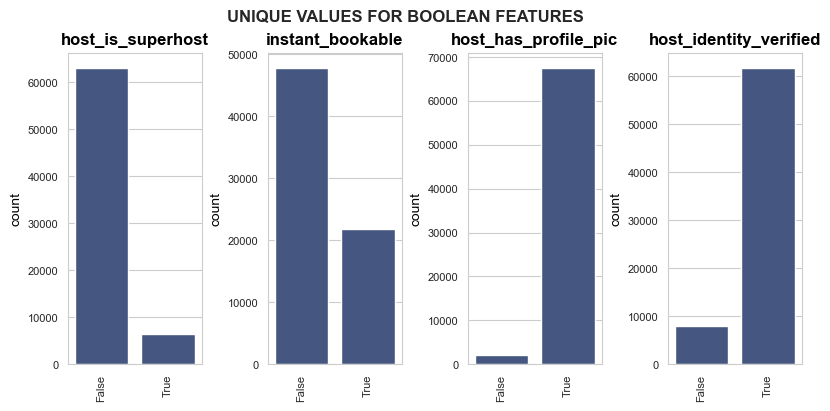

In [127]:
# check unique values per column
# print column unique values in a subplot grid
ncols = 4
nrows = len(cols) // ncols

fig, axs = plt.subplots(nrows, ncols, constrained_layout=True, figsize=(8,4))
for col, ax in zip(cols, axs.T.ravel()):
    sns.countplot(data=listing_clean, x=col, ax=ax, color=BASE_COLOR, orient='h')
    
    # rotate the xtick labels
    labels = ax.get_xticklabels()
    ax.set_xticklabels(labels, rotation=90)
    ax.set_title(col)
    ax.set_xlabel('')

plt.suptitle('UNIQUE VALUES FOR BOOLEAN FEATURES')
plt.show()

<span style="color:blue; font-size:16px; font-family: Calibri;">Issue #10: **host_response_rate**, **host_acceptance_rate** and **price** are numeric fields as type string with prefix '%' or '$' present</span>

**Define**: Remove '%' or '¢' from string and convert to integer using python method astype() and regex replace() methods

#### Code

In [128]:
cols = ['host_response_rate', 'host_acceptance_rate', 'price']

In [129]:
# snapshot before we start
listing_clean[cols][:10]

,host_response_rate,host_acceptance_rate,price
1,90%,68%,$69.00
2,100%,78%,$79.00
3,100%,47%,$100.00
4,100%,100%,$156.00
5,100%,68%,$65.00
6,NaN,NaN,$41.00
7,NaN,NaN,$132.00
8,100%,98%,$550.00
9,100%,100%,$60.00
10,100%,50%,$250.00


In [130]:
# first fill missing values with a 0 response rate
listing_clean[cols] = listing_clean[cols].fillna('0')

In [131]:
# remove % and convert to integer type
for col in cols:
    listing_clean[col] = listing_clean[col].str.replace('[%$,]','', regex=True).astype('float16')
    listing_clean[col] = listing_clean[col].astype('int16')

#### Test

In [132]:
# no more missing values are present
assert listing_clean[cols].isna().any().any() == False

In [133]:
# columns are now an integer
for col in cols:
    assert listing_clean[col].dtype == 'int16'

In [134]:
# visual check to compare shapshots before and after
listing_clean[cols][:10]

,host_response_rate,host_acceptance_rate,price
1,90,68,69
2,100,78,79
3,100,47,100
4,100,100,156
5,100,68,65
6,0,0,41
7,0,0,132
8,100,98,550
9,100,100,60
10,100,50,250


<span style="color:blue; font-size:16px; font-family: Calibri;">Issue #11: dataset **calendar**: **date** field is a string</span>

**Define:** Convert `date` to type datetime using `to_datetime` method

#### Code

In [135]:
calendar['date'] = pd.to_datetime(calendar['date'])

#### Test

In [136]:
assert calendar.date.dtype == 'datetime64[ns]'

<span style="color:blue; font-size:16px; font-family: Calibri;">Issue #12: dataset **calendar**: **price** is a numeric field presented as type string with prefix '$'</span>

**Define**: Remove '$' from string and convert to integer using python methods astype() and regex replace()

#### Code

In [137]:
# snapshot before we start
calendar_clean.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,13913,2023-06-09,f,$79.00,$79.00,1.0,29.0
1,13913,2023-06-10,f,$79.00,$79.00,1.0,29.0
2,13913,2023-06-11,f,$79.00,$79.00,1.0,29.0
3,13913,2023-06-12,t,$79.00,$79.00,1.0,29.0
4,13913,2023-06-13,t,$79.00,$79.00,1.0,29.0


In [138]:
# remove prefix '$'' and convert to integer type
calendar_clean['price']= calendar_clean['price'].str.replace('[$,]','', regex=True).astype('float32')

#### Test

In [139]:
assert calendar_clean['price'].dtype == 'float32'

<span style="color:blue; font-size:16px; font-family: Calibri;">Issue #13: convert float columns to integer (host_total_listings_count, minimum_minimum_nights, maximum_minimum_nights, number_of_reviews, number_of_reviews_ltm, number_of_reviews_l30d)</span>

**Define**: convert float to integer datatype using pandas method astype(), by first setting np.nan values to 0 using fillna() method

#### Code

In [140]:
cols = ['host_total_listings_count', 'minimum_minimum_nights', 'minimum_maximum_nights', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d']
listing_clean[cols] = round(listing_clean[cols],0).fillna(0).astype(int)

#### Test

In [141]:
for col in cols:
    assert listing_clean[col].dtype == 'int64'

<a id='consistency'></a>
<span style="color:blue; font-size:20px; font-family: Calibri;">Consistency Issues</span>

[click here to go back to summary of assessment](#sum_assessment)

<span style="color:blue; font-size:16px; font-family: Calibri;">Issue #14: **id** column in **listing** should be called **listing_id** to be consistent with **calendar** dataset</span>

**Define**: rename column `id` to `listing_id` using pandas method `rename()`

#### Code:

In [142]:
listing_clean.rename(columns={'id':'listing_id'}, inplace=True)

#### Test:

In [143]:
assert listing_clean.columns.str.contains('listing_id').any() == True

<a id='accuracy'></a>
<span style="color:blue; font-size:20px; font-family: Calibri;">Accuracy Issues</span>

[click here to go back to summary of assessment](#sum_assessment)

<span style="color:blue; font-size:16px; font-family: Calibri;">Issue #15: There are listings in the **calendar** dataset where prices increase significantly from one day to the next, e.g. £100 one day, £24,000 the next</span>

#### Define: find extreme jump in prices and replace these prices with np.nan. Fill missing prices using pandas first ffill() then bfill() methods

#### Code:

In [144]:
calendar_clean2 = calendar_clean.copy()

In [145]:
# sort now so we can keep index stable
calendar_clean.sort_values(by=['listing_id', 'date'], inplace=True)

In [146]:
# Example 1 - follow the listing with most extreme price over $80k - snapshot before we start
calendar_clean[calendar_clean['listing_id'] == 38452677]

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
13320335,38452677,2023-06-08,f,100.0,$100.00,2.0,"1,125.0"
13320336,38452677,2023-06-09,f,100.0,$100.00,2.0,"1,125.0"
13320337,38452677,2023-06-10,f,100.0,$100.00,2.0,"1,125.0"
13320338,38452677,2023-06-11,f,100.0,$100.00,2.0,"1,125.0"
13320339,38452677,2023-06-12,f,100.0,$100.00,2.0,"1,125.0"
13320340,38452677,2023-06-13,f,100.0,$100.00,2.0,"1,125.0"
13320341,38452677,2023-06-14,f,100.0,$100.00,2.0,"1,125.0"
13320342,38452677,2023-06-15,f,100.0,$100.00,2.0,"1,125.0"
13320343,38452677,2023-06-16,f,100.0,$100.00,2.0,"1,125.0"
13320344,38452677,2023-06-17,f,100.0,$100.00,2.0,"1,125.0"


In [147]:
# Example 2
calendar_clean.query('listing_id == 39218905')

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
13574643,39218905,2023-06-09,t,79.0,$79.00,1.0,7.0
13574644,39218905,2023-06-10,t,102.0,$102.00,1.0,7.0
13574645,39218905,2023-06-11,t,67.0,$67.00,1.0,7.0
13574646,39218905,2023-06-12,t,67.0,$67.00,1.0,7.0
13574647,39218905,2023-06-13,f,113.0,$113.00,1.0,7.0
13574648,39218905,2023-06-14,f,159.0,$159.00,1.0,7.0
13574649,39218905,2023-06-15,t,148.0,$148.00,1.0,7.0
13574650,39218905,2023-06-16,t,194.0,$194.00,1.0,7.0
13574651,39218905,2023-06-17,t,206.0,$206.00,2.0,7.0
13574652,39218905,2023-06-18,f,182.0,$182.00,1.0,7.0


In [148]:
# calculate the mean and standard deviation for each listing
calendar_stats = calendar_clean.groupby(['listing_id']).agg(mean=('price', 'mean'), 
                                                            std=('price', 'std'), 
                                                            min=('price', 'min'),
                                                            max=('price', 'max')).reset_index()
calendar_clean = calendar_clean.merge(calendar_stats, how='inner', on='listing_id')

In [149]:
# get listing id's with errors 
df_only_errors = calendar_clean[((calendar_clean['std'] >= calendar_clean['mean']) & 
                                 (calendar_clean['price'] > 100) &
                                 (calendar_clean['price'] > calendar_clean['min']*10)) | 
                                 ((calendar_clean['price'] > 100) &
                                 (calendar_clean['price'] > calendar_clean['min']*15))]
df_only_errors.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,mean,std,min,max
16227,79129,2023-11-23,f,"3,841.0","$3,841.00",1.0,120.0,132.7,555.9,35.0,"3,841.0"
16228,79129,2023-11-24,f,"3,841.0","$3,841.00",1.0,120.0,132.7,555.9,35.0,"3,841.0"
16229,79129,2023-11-25,f,"3,841.0","$3,841.00",1.0,120.0,132.7,555.9,35.0,"3,841.0"
16230,79129,2023-11-26,f,"3,841.0","$3,841.00",1.0,120.0,132.7,555.9,35.0,"3,841.0"
16231,79129,2023-11-27,f,"3,841.0","$3,841.00",1.0,120.0,132.7,555.9,35.0,"3,841.0"


In [150]:
calendar_clean[calendar_clean.listing_id == 42419808]

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,mean,std,min,max
14676679,42419808,2023-06-09,f,79.0,$79.00,2.0,14.0,704.9,438.8,37.0,"1,000.0"
14676680,42419808,2023-06-10,f,84.0,$84.00,2.0,14.0,704.9,438.8,37.0,"1,000.0"
14676681,42419808,2023-06-11,f,37.0,$37.00,2.0,14.0,704.9,438.8,37.0,"1,000.0"
14676682,42419808,2023-06-12,f,37.0,$37.00,2.0,14.0,704.9,438.8,37.0,"1,000.0"
14676683,42419808,2023-06-13,f,37.0,$37.00,2.0,14.0,704.9,438.8,37.0,"1,000.0"
14676684,42419808,2023-06-14,f,37.0,$37.00,2.0,14.0,704.9,438.8,37.0,"1,000.0"
14676685,42419808,2023-06-15,t,104.0,$104.00,1.0,3.0,704.9,438.8,37.0,"1,000.0"
14676686,42419808,2023-06-16,t,123.0,$123.00,2.0,2.0,704.9,438.8,37.0,"1,000.0"
14676687,42419808,2023-06-17,t,128.0,$128.00,2.0,1.0,704.9,438.8,37.0,"1,000.0"
14676688,42419808,2023-06-18,f,37.0,$37.00,2.0,14.0,704.9,438.8,37.0,"1,000.0"


In [151]:
# lets extract all listing records the error occur for
error_listings = df_only_errors['listing_id'].drop_duplicates().to_list()
print('{} listings with pricing jumps found'.format(len(error_listings)))
df_errors_all = calendar_clean[calendar_clean['listing_id'].isin(error_listings)]

448 listings with pricing jumps found


In [152]:
# compare the min and max price of each listing and double check it qualify as excessive
df_errors_grouped = df_errors_all.groupby('listing_id').agg(min_price=('price', 'min'), max_price=('price', 'max'))
df_errors_grouped.sample(30)

,min_price,max_price
listing_id,,
38452677,80.0,"80,100.0"
21777839,53.0,999.0
34770801,63.0,"1,570.0"
628633983820533539,122.0,"2,440.0"
8011127,69.0,"1,076.0"
635816208574073298,122.0,"2,440.0"
42872507,194.0,"2,310.0"
38920959,99.0,"1,324.0"
48051140,76.0,"1,570.0"


In [153]:
# fill excessive prices with null
calendar_clean.loc[df_only_errors.index, 'price'] = np.nan

In [154]:
# # fill missing prices using ffill, then bfill
calendar_clean['key'] = calendar_clean['listing_id']
calendar_clean = calendar_clean.groupby('key').ffill().bfill()

In [155]:
#### Test:

In [156]:
# follow the listing with most extreme price over $80k
calendar_clean[calendar_clean.listing_id == 38452677]

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,mean,std,min,max
13346249,38452677,2023-06-08,f,100.0,$100.00,2.0,"1,125.0","28,365.7","38,301.3",80.0,"80,100.0"
13346250,38452677,2023-06-09,f,100.0,$100.00,2.0,"1,125.0","28,365.7","38,301.3",80.0,"80,100.0"
13346251,38452677,2023-06-10,f,100.0,$100.00,2.0,"1,125.0","28,365.7","38,301.3",80.0,"80,100.0"
13346252,38452677,2023-06-11,f,100.0,$100.00,2.0,"1,125.0","28,365.7","38,301.3",80.0,"80,100.0"
13346253,38452677,2023-06-12,f,100.0,$100.00,2.0,"1,125.0","28,365.7","38,301.3",80.0,"80,100.0"
13346254,38452677,2023-06-13,f,100.0,$100.00,2.0,"1,125.0","28,365.7","38,301.3",80.0,"80,100.0"
13346255,38452677,2023-06-14,f,100.0,$100.00,2.0,"1,125.0","28,365.7","38,301.3",80.0,"80,100.0"
13346256,38452677,2023-06-15,f,100.0,$100.00,2.0,"1,125.0","28,365.7","38,301.3",80.0,"80,100.0"
13346257,38452677,2023-06-16,f,100.0,$100.00,2.0,"1,125.0","28,365.7","38,301.3",80.0,"80,100.0"
13346258,38452677,2023-06-17,f,100.0,$100.00,2.0,"1,125.0","28,365.7","38,301.3",80.0,"80,100.0"


In [157]:
# Example 2
calendar_clean.query('listing_id == 39218905')

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,mean,std,min,max
13587149,39218905,2023-06-09,t,79.0,$79.00,1.0,7.0,573.3,855.1,67.0,"2,310.0"
13587150,39218905,2023-06-10,t,102.0,$102.00,1.0,7.0,573.3,855.1,67.0,"2,310.0"
13587151,39218905,2023-06-11,t,67.0,$67.00,1.0,7.0,573.3,855.1,67.0,"2,310.0"
13587152,39218905,2023-06-12,t,67.0,$67.00,1.0,7.0,573.3,855.1,67.0,"2,310.0"
13587153,39218905,2023-06-13,f,113.0,$113.00,1.0,7.0,573.3,855.1,67.0,"2,310.0"
13587154,39218905,2023-06-14,f,159.0,$159.00,1.0,7.0,573.3,855.1,67.0,"2,310.0"
13587155,39218905,2023-06-15,t,148.0,$148.00,1.0,7.0,573.3,855.1,67.0,"2,310.0"
13587156,39218905,2023-06-16,t,194.0,$194.00,1.0,7.0,573.3,855.1,67.0,"2,310.0"
13587157,39218905,2023-06-17,t,206.0,$206.00,2.0,7.0,573.3,855.1,67.0,"2,310.0"
13587158,39218905,2023-06-18,f,182.0,$182.00,1.0,7.0,573.3,855.1,67.0,"2,310.0"


In [158]:
# Example 3
calendar_clean.query('listing_id == 42419808')

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,mean,std,min,max
14676679,42419808,2023-06-09,f,79.0,$79.00,2.0,14.0,704.9,438.8,37.0,"1,000.0"
14676680,42419808,2023-06-10,f,84.0,$84.00,2.0,14.0,704.9,438.8,37.0,"1,000.0"
14676681,42419808,2023-06-11,f,37.0,$37.00,2.0,14.0,704.9,438.8,37.0,"1,000.0"
14676682,42419808,2023-06-12,f,37.0,$37.00,2.0,14.0,704.9,438.8,37.0,"1,000.0"
14676683,42419808,2023-06-13,f,37.0,$37.00,2.0,14.0,704.9,438.8,37.0,"1,000.0"
14676684,42419808,2023-06-14,f,37.0,$37.00,2.0,14.0,704.9,438.8,37.0,"1,000.0"
14676685,42419808,2023-06-15,t,104.0,$104.00,1.0,3.0,704.9,438.8,37.0,"1,000.0"
14676686,42419808,2023-06-16,t,123.0,$123.00,2.0,2.0,704.9,438.8,37.0,"1,000.0"
14676687,42419808,2023-06-17,t,128.0,$128.00,2.0,1.0,704.9,438.8,37.0,"1,000.0"
14676688,42419808,2023-06-18,f,37.0,$37.00,2.0,14.0,704.9,438.8,37.0,"1,000.0"


In [159]:
# make sure there are no missing price values
assert calendar_clean.price.isna().any() == False

<span style="color:blue; font-size:16px; font-family: Calibri;">Issue #16: daily price in listings is not always the average mean price from the calendar dataset</span>

**Define:** Recalculate listing base price to be mean calendar price and save as new column `price_mean`

#### Code:

In [160]:
calendar_mean = calendar_clean.groupby('listing_id', as_index=False).agg(price_mean=('price','mean')).round(0).astype(int)
calendar_mean.head()

,listing_id,price_mean
0,13913,79
1,15400,107
2,17402,527
3,24328,250
4,25123,29


In [161]:
# add mean price to lising dataset
listing_clean = listing_clean.merge(calendar_mean, on='listing_id', how='inner')

#### Test:

In [162]:
# compare orginal base price to new mean base price
listing_clean[['listing_id', 'price', 'price_mean']].sample(10)

,listing_id,price,price_mean
29830,44259455,36,36
19248,28279185,51,51
15634,22591850,220,220
36340,53184459,1513,1681
10051,15954078,25,29
7020,11424164,100,100
2195,3889597,160,160
43475,658627148683494040,350,350
66380,890322773585127837,30,30
3555,6316209,40,40


In [163]:
# compare original price to new mean price after cleaning for listings with the biggest inconsistencies
listing_clean[listing_clean.listing_id.isin(calendar_grouped[:5]['listing_id'])][['listing_id', 'price', 'price_mean']]

,listing_id,price,price_mean
21158,31622680,7580,78
25592,38452677,100,92
30125,44696103,8584,115
35030,51839279,24000,256
43547,658361293784718707,27584,139


<span style="color:blue; font-size:16px; font-family: Calibri;"> Issue #17: `minimum_maximum_nights` have some crazy maximum values > 90 mil !</span>

**Define:** Override values in feature minimum_maximum_nights >= 90000 with 1125 (value from percentile 0.999)

**Code**:

In [164]:
# get rows that needs to be changed
df_max_nights_error = listing_clean[listing_clean['minimum_maximum_nights'] >= 9000000]
df_max_nights_error.shape

(9, 78)

In [165]:
# fill excessive prices with 1125
listing_clean.loc[df_max_nights_error.index, 'minimum_maximum_nights'] = 1125

**Test**:

In [166]:
assert len(listing_clean[listing_clean['minimum_maximum_nights'] >= 9000000]) == 0

<a id='tidiness'></a>
<span style="color:blue; font-size:20px; font-family: Calibri;">Tidiness Issues</span>

[click here to go back to summary of assessment](#sum_assessment)

<span style="color:blue; font-size:16px; font-family: Calibri;"> Issue #18: **bathroom_text** contains more than one meaning: number of baths and shared vs private</span>

**Define:** Create new boolean feature called 'private_bathroom' with rules:

- when room_type = 'Entire home/apt' set to True
- when word 'shared' is found within bathroom_text, set to False
- when number of bathrooms = 0, set to False
- when number of bathrooms is missing, set to False
- otherwise True

**Code**:

In [167]:
# extract the word private or shared from bathroom_text
listing_clean['private_bathroom'] = listing_clean['bathrooms_text'].str.extract('([Ss]hared|[Pp]rivate)', expand=True)

In [168]:
# create boolean feature to indicate if listing have a private bathroom or not
listing_clean['private_bathroom'] = np.where((listing_clean['room_type'] == 'Entire home/apt'), True, 
                                    np.where((listing_clean['bathrooms'] == 0), False,     
                                    np.where((listing_clean['bathrooms'].isna()), False,  
                                    np.where((listing_clean['private_bathroom'] == 'shared'), False, True))))    

**Test**:

In [169]:
# visual inspection destination
listing_clean['private_bathroom'][:10]

0     True
1    False
2     True
3     True
4    False
5    False
6     True
7     True
8     True
9     True
Name: private_bathroom, dtype: bool

In [170]:
# visual inspection source
listing_clean['bathrooms_text'][:10]

0        1.5 baths
1    1 shared bath
2           1 bath
3           1 bath
4    1 shared bath
5          0 baths
6           1 bath
7          2 baths
8           1 bath
9        1.5 baths
Name: bathrooms_text, dtype: object

In [171]:
# make sure no records exist where bathrooms_text contain the string 'shared' and new feature 'private_bathroom'
assert len(listing_clean[(listing_clean['bathrooms_text'].str.contains('shared', regex=False)) & 
                  (listing_clean['private_bathroom'] == True)]) == 0 

In [172]:
listing_clean['private_bathroom'].value_counts()

private_bathroom
True     54988
False    14589
Name: count, dtype: int64

In [173]:
# make sure private bathrooms have no null values
assert listing_clean['private_bathroom'].isna().sum() == 0

In [174]:
# how many records have 0 bathrooms ?
len(listing_clean[listing_clean['bathrooms'] == 0])

173

<span style="color:blue; font-size:16px; font-family: Calibri;"> Issue #19: Drop unneeded variables</span>

**Define**: Drop fields not needed for this project by using pandas method drop()

#### Code

In [175]:
cols_to_drop = ['scrape_id', 'last_scraped', 'source', 'description', 'host_url',
                'picture_url', 'host_since', 'host_location', 'host_thumbnail_url', 'host_picture_url', 
                'neighbourhood', 'bathrooms_text', 'host_verifications',
                'neighborhood_overview', 'host_about',
                'minimum_nights', 'maximum_minimum_nights', 'minimum_nights_avg_ntm',
                'maximum_nights', 'maximum_maximum_nights', 'maximum_nights_avg_ntm',                
                'has_availability', 'host_listings_count', 'host_total_listings_count',
#                 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 
#                 'review_scores_communication', 'review_scores_location', 'review_scores_value',
                'amenities', 'calendar_last_scraped', 'extracted_bedrooms_name', 'studio_name']

In [176]:
listing_clean.drop(cols_to_drop, inplace=True, axis=1, errors='ignore')

#### Test

In [177]:
# check that all specified columns were removed
assert listing_clean.columns.isin(cols_to_drop).any() == False

<span style="color:blue; font-size:16px; font-family: Calibri;"> Issue #20: Optimize data types and memory</span>

**Define**: Reduce integer and float types to minimum needed e.g. int64 to int8 for small numberes

#### Code

In [178]:
# before
# listing_clean.info()

In [179]:
# listing_clean = reduce_mem_usage(listing_clean)

#### Test

In [180]:
# listing_clean.info()

#### Issue #8:  If `number_of_reviews` = 0, all other review fields are missing TODO still needed ?

**Define**: Replace missing review values with 0 and missing dates with dummy date '1900-01-01' using pandas method fillna()

In [181]:
#### Code

In [182]:
# # fill missing scores with 0
# review_cols = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
#               'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value',
#               'reviews_per_month']

# listing_clean[review_cols] = listing_clean[review_cols].fillna(0)

In [183]:
# # fill missing dates with a dummy date
# review_year_cols = ['first_review', 'last_review']
# listing_clean[review_year_cols] = listing_clean[review_year_cols].fillna('1900-01-01')

In [184]:
#### Test

In [185]:
# make sure review columns have no more missing values
# assert listing_clean[review_cols].isna().any().any() == False

In [186]:
# we expect 20602 records with have a dummy date
# assert len(listing_clean[listing_clean['first_review'] == '1900-01-01']) == 20602

<a id='save'></a>
<span style="color:blue; font-size:25px; line-height:30px; font-family: Calibri;">Step 4: Save cleaned data</span>

In [187]:
listing_clean.shape

(69577, 51)

In [188]:
listing_clean.head()

,listing_id,listing_url,name,host_id,host_name,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,minimum_minimum_nights,minimum_maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_has_about,host_has_neighborhood_overview,host_years_active,price_mean,private_bathroom
0,157714,https://www.airbnb.com/rooms/157714,Townhouse in Hammersmith · ★4.71 · 1 bedroom ·...,757377,Eilinn,within a few hours,90,68,False,Hammersmith,True,True,Hammersmith and Fulham,51.5,-0.2,Private room in townhouse,Private room,3,1.5,1.0,1.0,69,4,21,10,37,67,67,175,10,0,2011-07-13,2023-05-02,4.7,4.7,4.8,4.8,4.8,4.8,4.7,False,1,0,1,0,1.2,True,True,12,70,True
1,13913,https://www.airbnb.com/rooms/13913,Rental unit in Islington · ★4.80 · 1 bedroom ·...,54730,Alina,within an hour,100,78,False,LB of Islington,True,True,Islington,51.6,-0.1,Private room in rental unit,Private room,1,1.0,1.0,1.0,79,1,29,23,48,78,353,41,15,0,2010-08-18,2022-12-11,4.8,4.7,4.7,4.7,4.8,4.7,4.7,False,2,1,1,0,0.3,True,True,14,79,False
2,15400,https://www.airbnb.com/rooms/15400,Rental unit in London · ★4.80 · 1 bedroom · 1 ...,60302,Philippa,within a day,100,47,False,Chelsea,True,True,Kensington and Chelsea,51.5,-0.2,Entire rental unit,Entire home/apt,2,1.0,1.0,1.0,100,7,30,0,2,2,70,94,5,0,2009-12-21,2023-05-01,4.8,4.8,4.9,4.9,4.8,4.9,4.7,False,1,1,0,0,0.6,True,True,14,107,True
3,306333,https://www.airbnb.com/rooms/306333,Rental unit in London · ★4.32 · 2 bedrooms · 3...,1573870,Robert,within a day,100,100,False,Shoreditch,True,True,Hackney,51.5,-0.1,Entire rental unit,Entire home/apt,5,1.0,2.0,3.0,156,2,60,4,4,4,4,20,0,0,2016-12-18,2017-05-31,4.3,4.7,4.0,4.3,4.8,4.9,4.5,False,1,1,0,0,0.2,True,True,11,198,True
4,159736,https://www.airbnb.com/rooms/159736,Rental unit in Lambeth · ★4.72 · 1 bedroom · 1...,766056,Trevor,within an hour,100,68,False,Stockwell,True,True,Lambeth,51.5,-0.1,Private room in rental unit,Private room,2,1.0,1.0,1.0,65,4,1125,1,1,2,160,96,4,0,2011-07-16,2023-04-29,4.7,4.8,4.7,4.8,4.9,4.3,4.7,False,4,0,4,0,0.7,True,True,12,62,False


In [189]:
# final look at data types and missing values
listing_clean.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69577 entries, 0 to 69576
Data columns (total 51 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   listing_id                                    69577 non-null  int64  
 1   listing_url                                   69577 non-null  object 
 2   name                                          69577 non-null  object 
 3   host_id                                       69577 non-null  int64  
 4   host_name                                     69577 non-null  object 
 5   host_response_time                            52186 non-null  object 
 6   host_response_rate                            69577 non-null  int16  
 7   host_acceptance_rate                          69577 non-null  int16  
 8   host_is_superhost                             69577 non-null  bool   
 9   host_neighbourhood                            37903 non-null 

In [190]:
# save the consolidated cleaned file as pickle file to preserve the datatype corrections
create_folder(FILE_PATH_CLEAN)
listing_clean.to_pickle(FILE_NAME_CLEAN)

### What is the structure of your dataset?

> The cleaned dataset have 31218803 rows and 29 columns

35417 out of +/- 30mil records was dropped due to incorrect time formats and large negative AirTime caused by large taxiIn values which looked like data calculation errors

### What is/are the main feature(s) of interest in your dataset?

> I will concentrate my analysis to discover the features that cause flight delays 

The target columns of interest are arrival delays (`arrDelay`) and departure delays (`depDelay`)

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

From experience, I would expect that delays are seasonal. In summer months, there are more demands and passenger volume throughput through airports, causing delays due to overcrowed airports. I would also expect, more delays would happen in some airports due to my experience in the UK. For example Manchester airport is one to be avoided with always a lot of delays caused by staffing issues and the way the airport is run. Does the same happen in the US? Do we have enough data to proof this ?

We have the following features available that could influence delays:
- Departure and arrival destinations
- Carriers
- Seasonal trends (e.g. winter vs summer)
- Days of the week

Questions to guide the analysis:
- When is the best time of day/day of week/time of year to fly to minimise delays?
- Are the problems caused by short or long haul flights ? 
- If departure is delayed to which extend do we make up time the time in the air before arrival ?
- How does the number of people flying between different locations change over time?
- Does certain destinations/carriers cause the delays ?
- Can you detect cascading failures as delays in one airport create delays in others? Are there critical links in the system?
- How well does weather predict plane delays?
- Do older planes suffer more delays?

<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">References</span>

- [how to plot side by side](https://stackoverflow.com/questions/71521800/how-to-iterate-subplots-by-columns-instead-of-rows-in-matplotlib)
- [mixing missingno bug](https://stackoverflow.com/questions/75525029/msno-matrix-shows-an-error-when-i-use-any-venv-using-pyenv)
- [extract number before a list of words](https://stackoverflow.com/questions/73298502/use-regex-to-extract-number-before-a-list-of-words-in-pandas-dataframe)

<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Submission</span>

In [191]:
# convert notebook to html
os.system('jupyter nbconvert --to html Part_I_data_wrangling.ipynb')

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
Traceback (most recent call last):
  File "/opt/anaconda3/envs/ds_udacity_projects/bin/jupyter-nbconvert", line 10, in <module>
    sys.exit(main())
  File "/opt/anaconda3/envs/ds_udacity_projects/lib/python3.10/site-packages/jupyter_core/application.py", line 280, in launch_instance
    super().launch_instance(argv=argv, **kwargs)
  File "/opt/anaconda3/envs/ds_udacity_projects/lib/python3.10/site-packages/traitlets/config/application.py", line 1053, in launch_instance
    app.start()
  File "/opt/anaconda3/envs/ds_udacity_projects/lib/python3.10/site-packages/nbconvert/nbconvertapp.py", line 412, in start
    self.convert_notebooks()
  File "/opt/anaconda3/envs/ds_udacity_projects/lib/python3.10/site-packages/nbconvert/nbconvertapp.py", line 579, in convert_notebooks
    self.exporter = cls(config=self.config)
  File "/opt/anaconda3/envs/ds_udacity_projects/lib/python3.10/site-package

256